<a href="https://colab.research.google.com/github/Ekarpova/Project_Find_My_Dress/blob/main/EKarpova_Siamese2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Ekarpova/Project_Find_My_Dress.git

Cloning into 'Project_Find_My_Dress'...
remote: Enumerating objects: 328, done.
remote: Counting objects: 100% (328/328), done.
remote: Compressing objects: 100% (315/315), done.
remote: Total 328 (delta 78), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (328/328), 5.67 MiB | 16.16 MiB/s, done.
Resolving deltas: 100% (78/78), done.


In [2]:
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [3]:
! [ -e /content ] && pip install -Uqq fastai

     |████████████████████████████████| 189 kB 5.1 MB/s 
     |████████████████████████████████| 56 kB 5.7 MB/s 


In [4]:
from fastai.data.external import untar_data,URLs
from fastai.data.transforms import get_image_files
from fastai.vision.all import *
import PIL
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid

In [5]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [6]:
def rgb_display(path1, path2):
    image1 = mpimg.imread(path1)
    image2 = mpimg.imread(path2)
    
    plt.axis("off")
    #fig = plt.figure(figsize=(4., 4.))
    fig = plt.figure(figsize=[20, 20])
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 2),  # creates 2x2 grid of axes
                 axes_pad=0,  # pad between axes in inch.
                 )
     
    for ax, im in zip(grid, [image1, image2]):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)


    return plt.show()

In [15]:
class Config():
    
   
    training_dir = "/content/Project_Find_My_Dress/data/train"
    eval_dir = "/content/Project_Find_My_Dress/data/eval_data"
    anchor_folder = "/content/Project_Find_My_Dress/data/original"
    test_folder = "/content/Project_Find_My_Dress/data/test"
    
    train_batch_size = 64
    train_number_epochs = 100

In [8]:
Config.training_dir

'/content/sample_data/Project_Find_My_Dress/data/train'

In [ ]:
files_anchor = get_image_files(Config.anchor_folder)
files_anchor[5]

Path('gdrive/My Drive/MyProject_colab/data/train/gown/gown_4.jpg')

In [9]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32)),img0_tuple[0],img1_tuple[0]
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [16]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [17]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

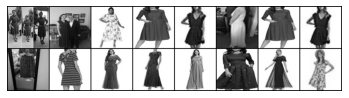

[[0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]]


In [18]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [19]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

DEFINING CONTRASTIVE LOSS

In [20]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

TRAINING STARTS **HERE** 

In [21]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [22]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [23]:
def train():
    counter = []
    loss_history = [] 
    iteration_number= 0
    for epoch in range(0,Config.train_number_epochs):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label,_,_ = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            if i %10 == 0 :
                print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
                iteration_number +=10
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())
                show_plot(counter,loss_history)
    return net

Epoch number 0
 Current loss 0.17881353199481964



Epoch number 1
 Current loss 0.20991122722625732



Epoch number 2
 Current loss 0.17226336896419525



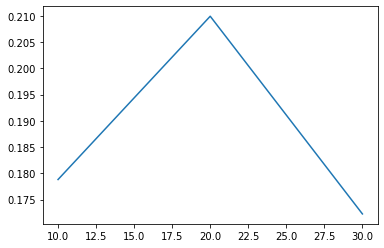

Epoch number 3
 Current loss 0.1869785040616989



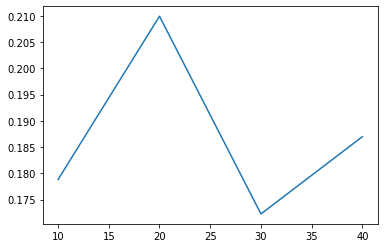

Epoch number 4
 Current loss 0.10342517495155334



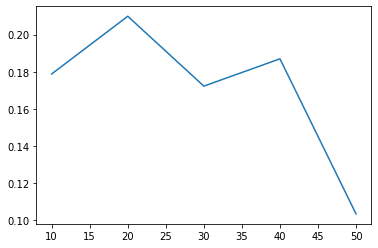

Epoch number 5
 Current loss 0.11827749013900757



Epoch number 6
 Current loss 0.13587293028831482



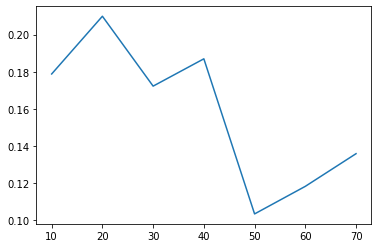

Epoch number 7
 Current loss 0.14650286734104156



Epoch number 8
 Current loss 0.16030022501945496



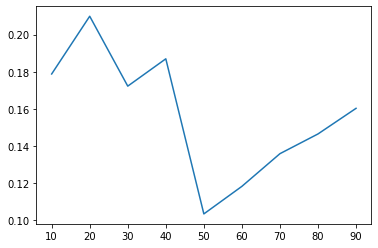

Epoch number 9
 Current loss 0.13853120803833008



Epoch number 10
 Current loss 0.1573992669582367



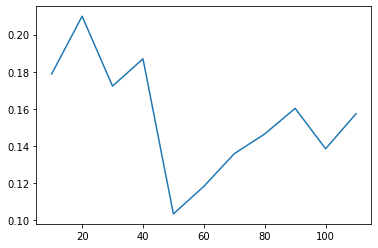

Epoch number 11
 Current loss 0.10417677462100983



Epoch number 12
 Current loss 0.09103120863437653



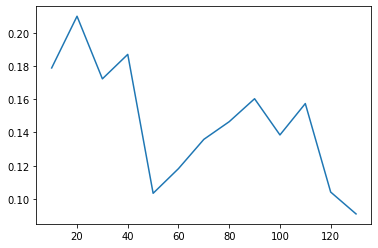

Epoch number 13
 Current loss 0.08385682106018066



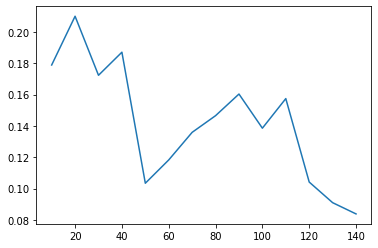

Epoch number 14
 Current loss 0.06635468453168869



Epoch number 15
 Current loss 0.05895349010825157



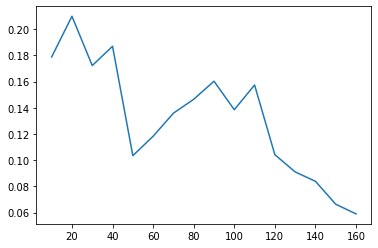

Epoch number 16
 Current loss 0.0807337611913681



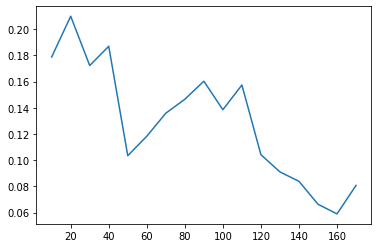

Epoch number 17
 Current loss 0.09239305555820465



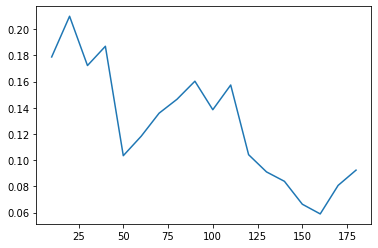

Epoch number 18
 Current loss 0.06553509831428528



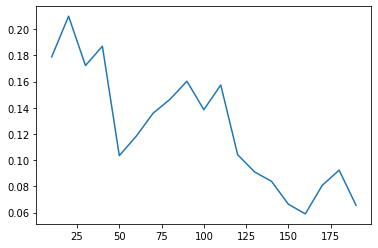

Epoch number 19
 Current loss 0.10717683285474777



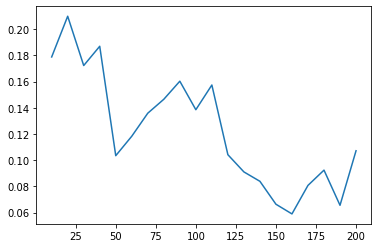

Epoch number 20
 Current loss 0.09645111113786697



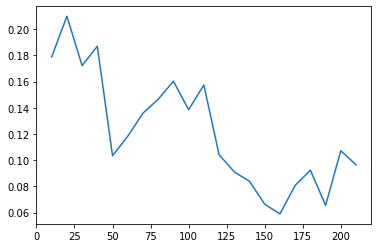

Epoch number 21
 Current loss 0.060907915234565735



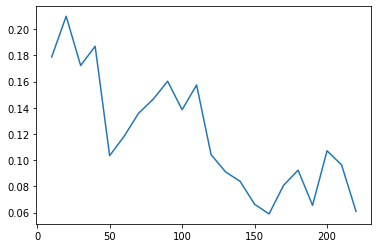

Epoch number 22
 Current loss 0.07793158292770386



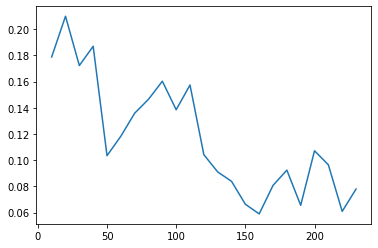

Epoch number 23
 Current loss 0.06508393585681915



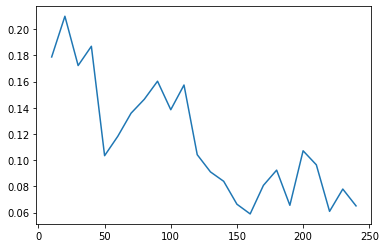

Epoch number 24
 Current loss 0.036735936999320984



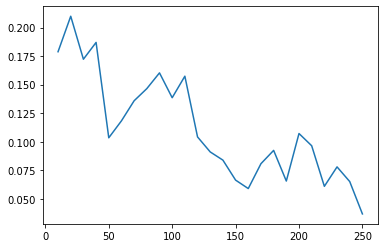

Epoch number 25
 Current loss 0.05354839563369751



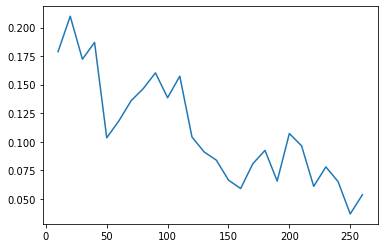

Epoch number 26
 Current loss 0.0648253932595253



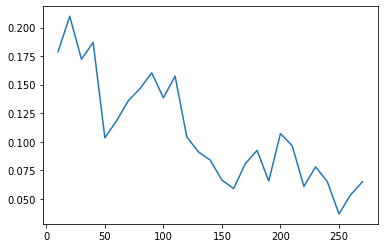

Epoch number 27
 Current loss 0.03120499476790428



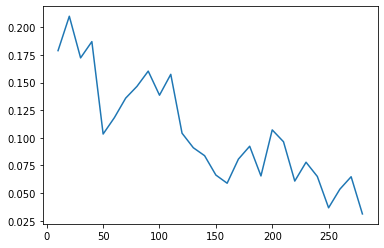

Epoch number 28
 Current loss 0.04420851543545723



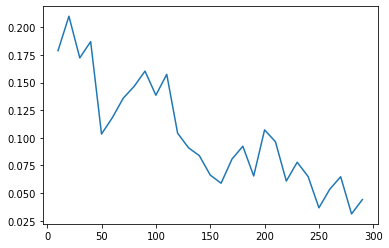

Epoch number 29
 Current loss 0.04361848533153534



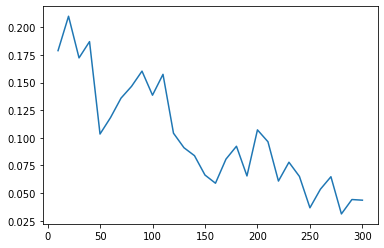

Epoch number 30
 Current loss 0.042063646018505096



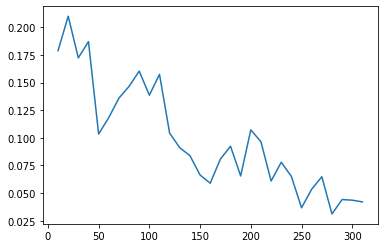

Epoch number 31
 Current loss 0.08111783862113953



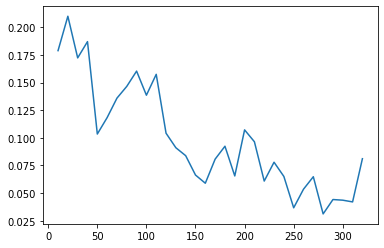

Epoch number 32
 Current loss 0.059128716588020325



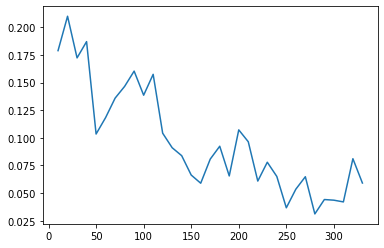

Epoch number 33
 Current loss 0.06875830888748169



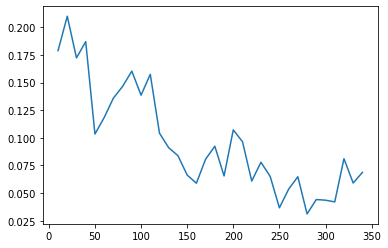

Epoch number 34
 Current loss 0.11983545124530792



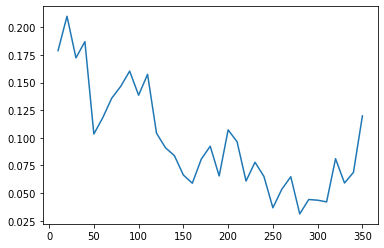

Epoch number 35
 Current loss 0.0872679352760315



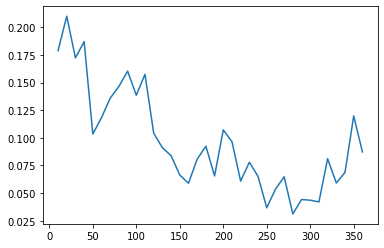

Epoch number 36
 Current loss 0.08887747675180435



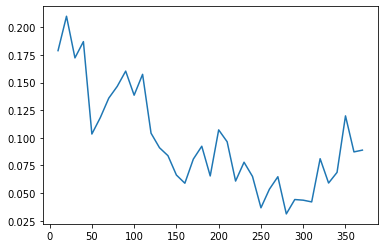

Epoch number 37
 Current loss 0.10955806821584702



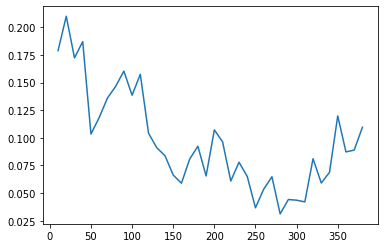

Epoch number 38
 Current loss 0.06938119977712631



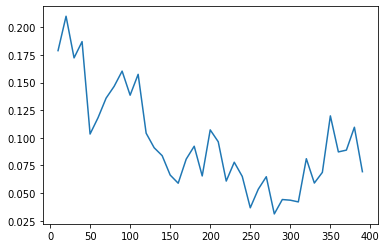

Epoch number 39
 Current loss 0.0682293027639389



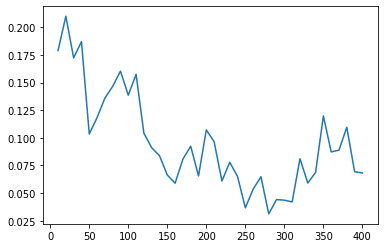

Epoch number 40
 Current loss 0.1363566368818283



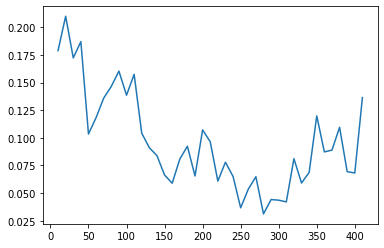

Epoch number 41
 Current loss 0.07097065448760986



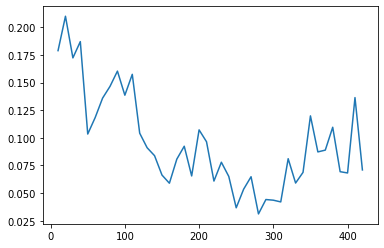

Epoch number 42
 Current loss 0.07056085020303726



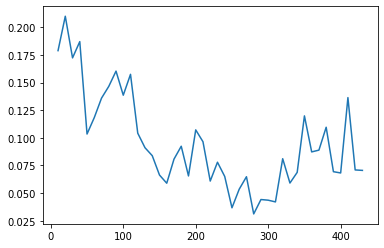

Epoch number 43
 Current loss 0.09618709236383438



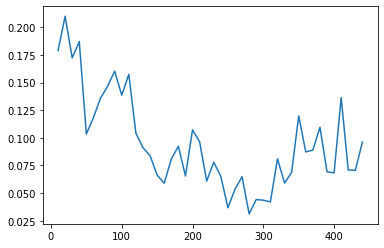

Epoch number 44
 Current loss 0.09776172786951065



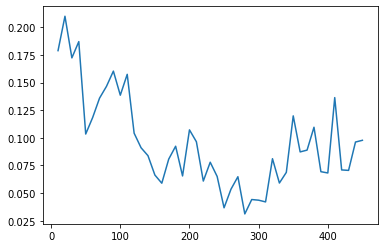

Epoch number 45
 Current loss 0.061067819595336914



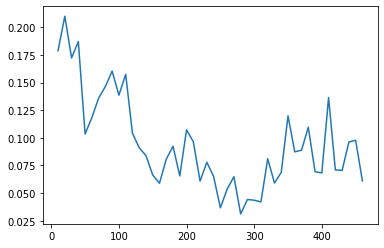

Epoch number 46
 Current loss 0.06598010659217834



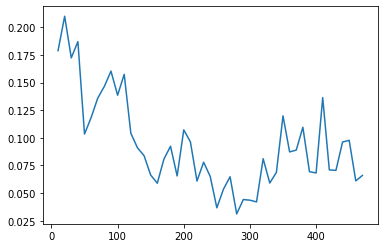

Epoch number 47
 Current loss 0.05171891301870346



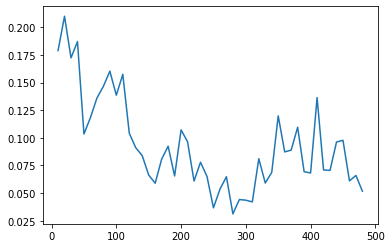

Epoch number 48
 Current loss 0.06899575889110565



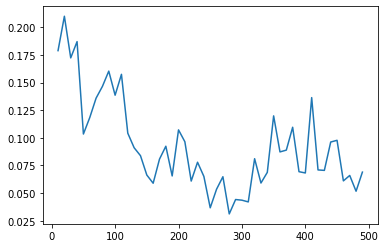

Epoch number 49
 Current loss 0.07550341635942459



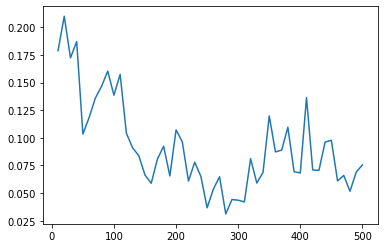

Epoch number 50
 Current loss 0.08916380256414413



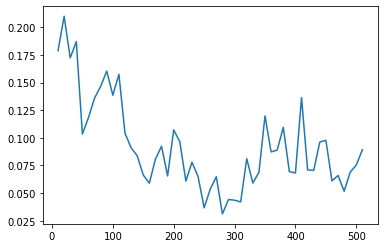

Epoch number 51
 Current loss 0.09298281371593475



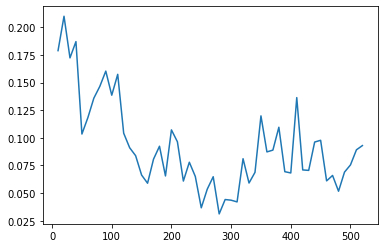

Epoch number 52
 Current loss 0.12031333893537521



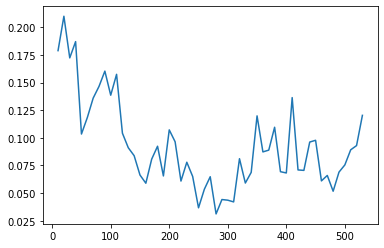

Epoch number 53
 Current loss 0.1271025389432907



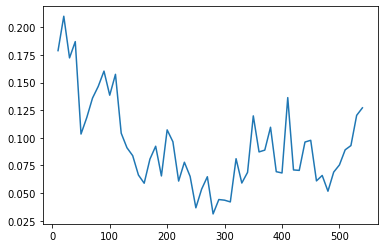

Epoch number 54
 Current loss 0.07058659195899963



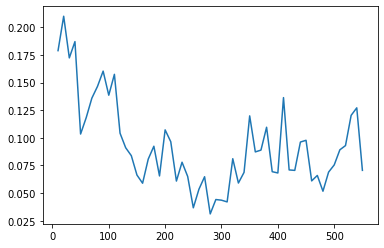

Epoch number 55
 Current loss 0.06051729619503021



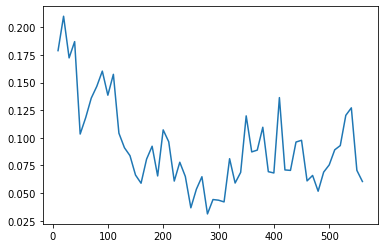

Epoch number 56
 Current loss 0.08592700958251953



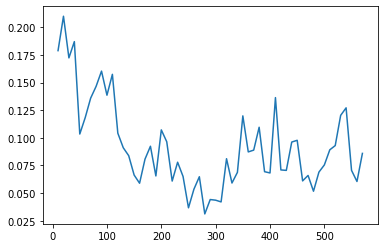

Epoch number 57
 Current loss 0.06997425854206085



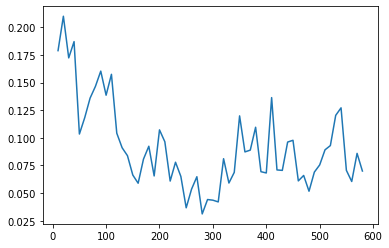

Epoch number 58
 Current loss 0.08292851597070694



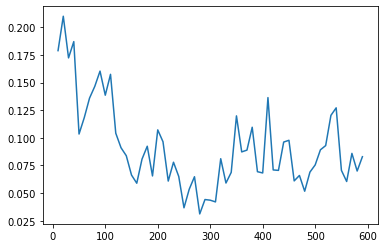

Epoch number 59
 Current loss 0.06161654740571976



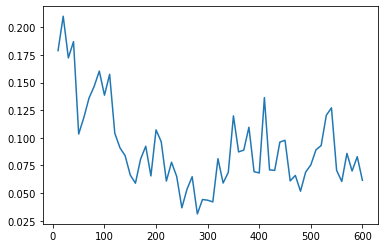

Epoch number 60
 Current loss 0.0816832184791565



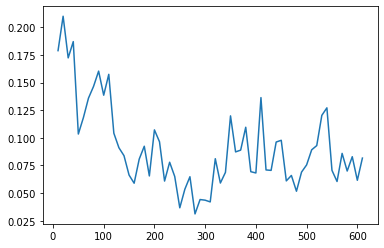

Epoch number 61
 Current loss 0.09502077102661133



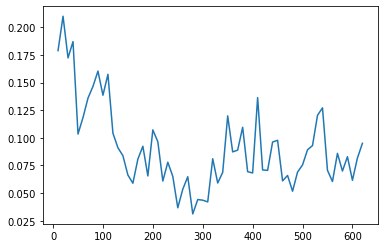

Epoch number 62
 Current loss 0.04726850986480713



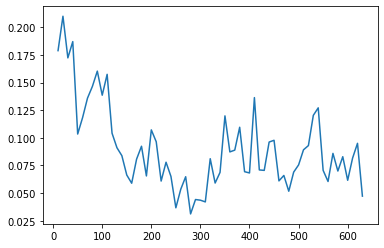

Epoch number 63
 Current loss 0.054923899471759796



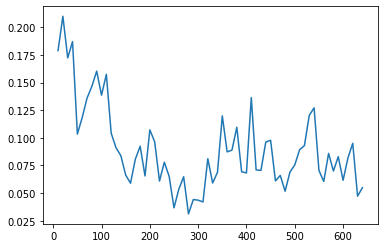

Epoch number 64
 Current loss 0.042285919189453125



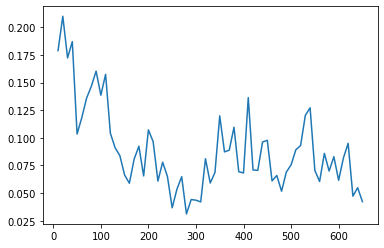

Epoch number 65
 Current loss 0.0783809944987297



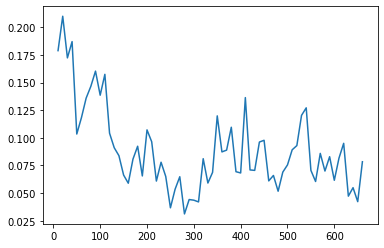

Epoch number 66
 Current loss 0.06684276461601257



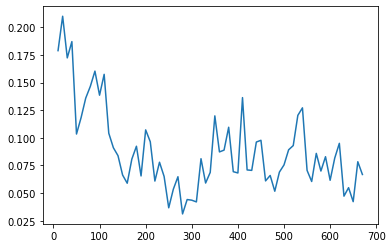

Epoch number 67
 Current loss 0.050791122019290924



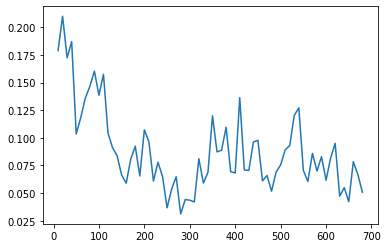

Epoch number 68
 Current loss 0.052372902631759644



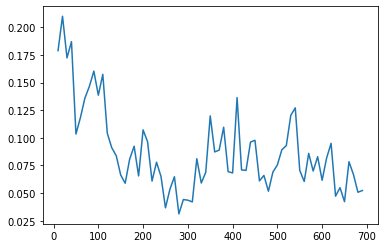

Epoch number 69
 Current loss 0.08774325251579285



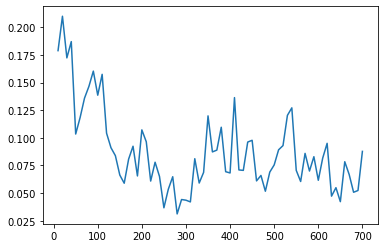

Epoch number 70
 Current loss 0.11610455811023712



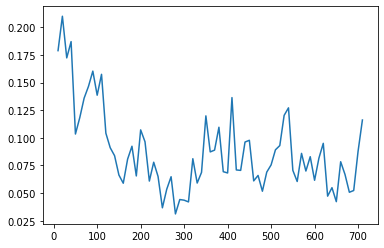

Epoch number 71
 Current loss 0.041920218616724014



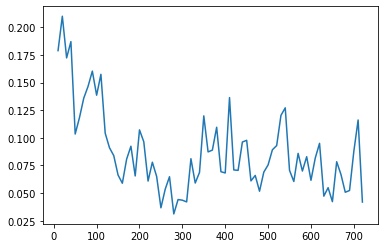

Epoch number 72
 Current loss 0.04516654461622238



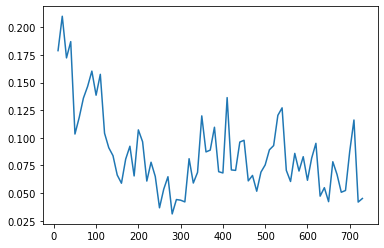

Epoch number 73
 Current loss 0.04119370877742767



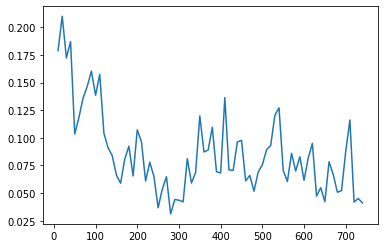

Epoch number 74
 Current loss 0.045223139226436615



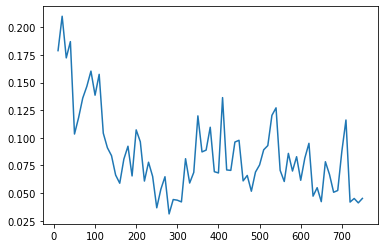

Epoch number 75
 Current loss 0.05428339168429375



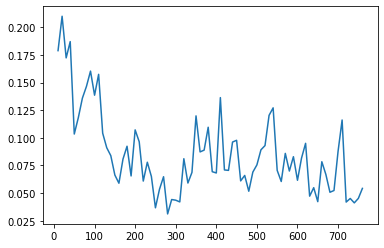

Epoch number 76
 Current loss 0.060761623084545135



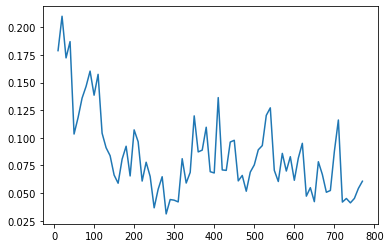

Epoch number 77
 Current loss 0.04049178212881088



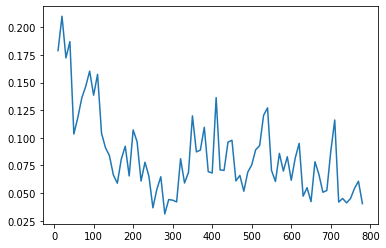

Epoch number 78
 Current loss 0.06007952243089676



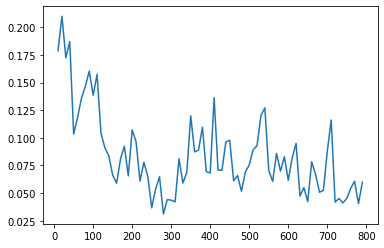

Epoch number 79
 Current loss 0.0667990893125534



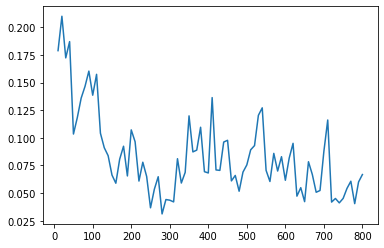

Epoch number 80
 Current loss 0.05195552855730057



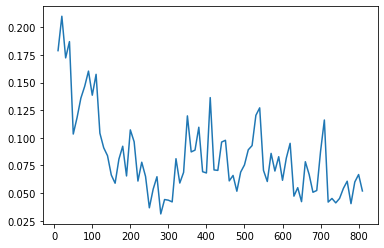

Epoch number 81
 Current loss 0.09210897237062454



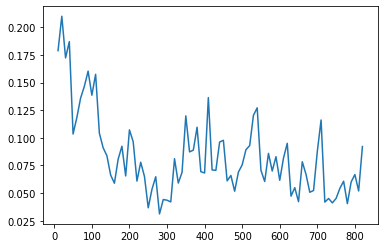

Epoch number 82
 Current loss 0.04526258260011673



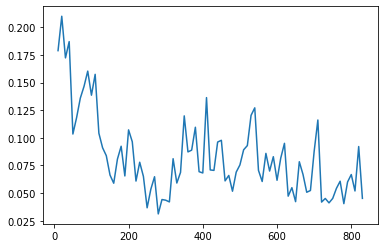

Epoch number 83
 Current loss 0.06751254200935364



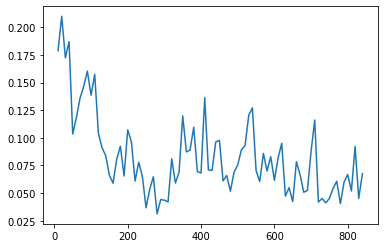

Epoch number 84
 Current loss 0.15994754433631897



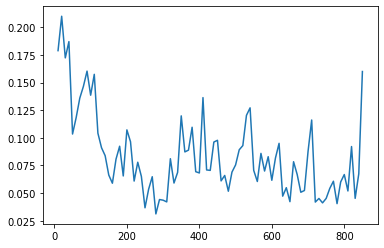

Epoch number 85
 Current loss 0.20057520270347595



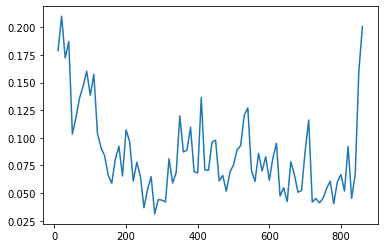

Epoch number 86
 Current loss 0.08772324025630951



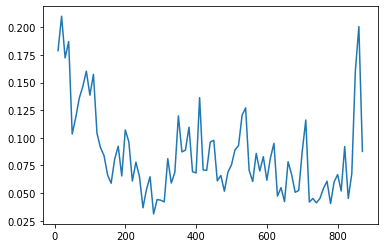

Epoch number 87
 Current loss 0.11048160493373871



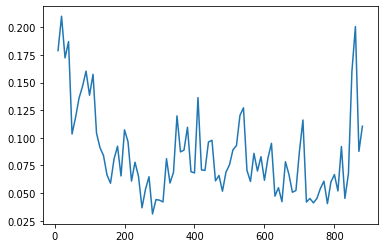

Epoch number 88
 Current loss 0.12306985259056091



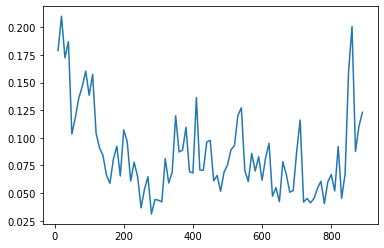

Epoch number 89
 Current loss 0.15186867117881775



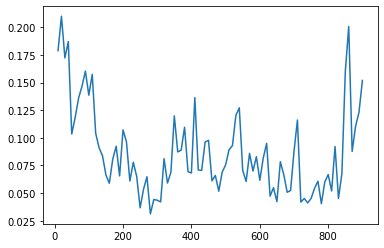

Epoch number 90
 Current loss 0.19134029746055603



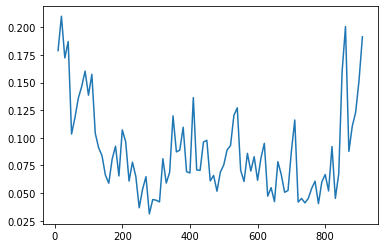

Epoch number 91
 Current loss 0.15188056230545044



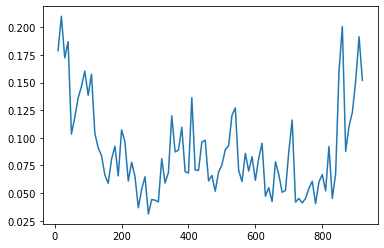

Epoch number 92
 Current loss 0.08691957592964172



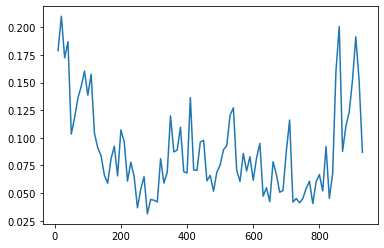

Epoch number 93
 Current loss 0.17937707901000977



Epoch number 94
 Current loss 0.0921192541718483



Epoch number 95
 Current loss 0.0890536680817604



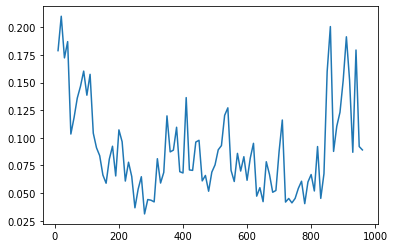

Epoch number 96
 Current loss 0.09282077848911285



Epoch number 97
 Current loss 0.1788935363292694



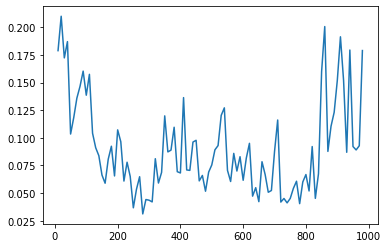

Epoch number 98
 Current loss 0.1029273271560669



Epoch number 99
 Current loss 0.09786611795425415



In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Training the model
model = train()

In [40]:
torch.save(model.state_dict(), "/content/Project_Find_My_Dress/data/SiameseNet2.pt")
print("Model Saved Successfully")

Model Saved Successfully


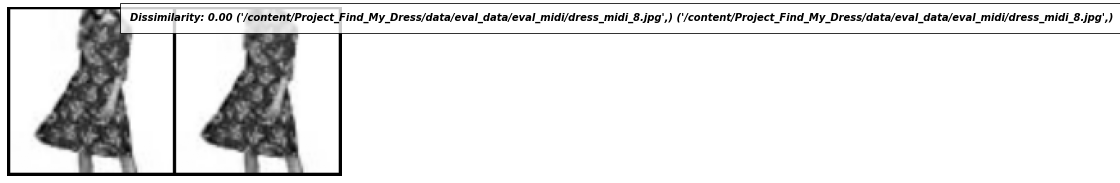

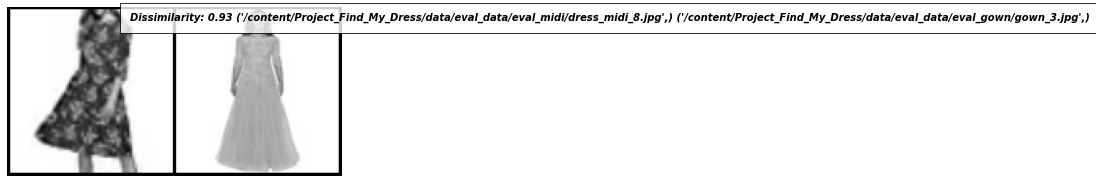

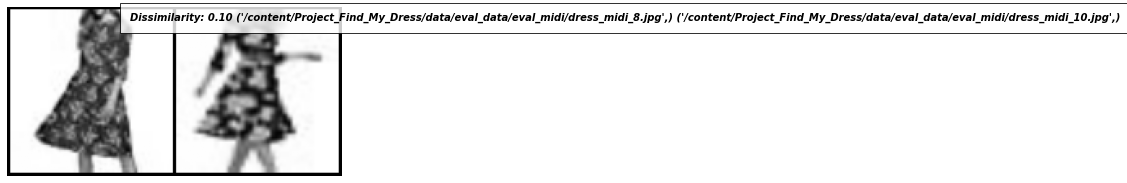

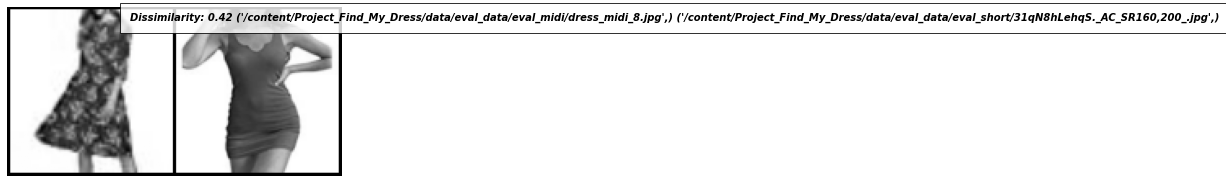

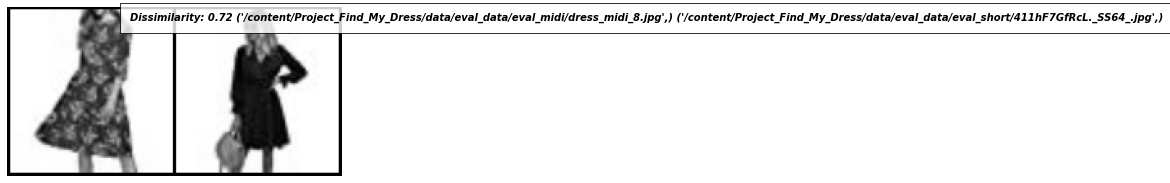

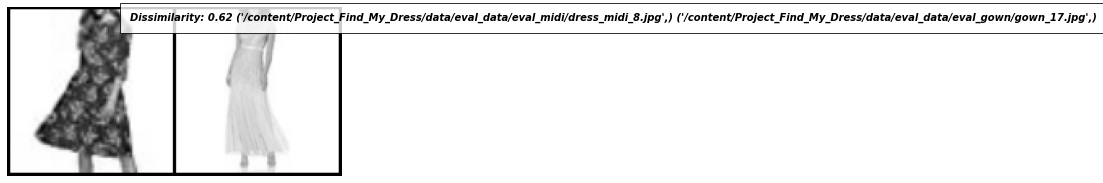

In [41]:
folder_dataset_test = dset.ImageFolder(root=Config.eval_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_,label0,_ = next(dataiter)

x0.size()

for i in range(10):
    _,x1,label2,_,label1 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} {} {}'.format(euclidean_distance.item(), label0, label1))



In [42]:
files_anchor = get_image_files(Config.anchor_folder)
files_test = get_image_files(Config.test_folder)
files_test[2]


Path('/content/Project_Find_My_Dress/data/test/short_6.jpg')

In [43]:
pairs_list = []

for i in range(len(files_test)):
   
    #print(label_func(files_test[i]))
    for k in range(len(files_anchor)):        
          pair = (files_anchor[i],files_test[k-i])
          pairs_list.append(pair)
          break
    

In [34]:
#pairs_list

In [44]:

def euclidean_distance_image(fn0,fn1):
    "Open and load a `PIL.Image` and convert to `Tensor` and calculate euclidean distance"
    
    
    img0Test = Image.open(fn0)
    img1Test = Image.open(fn1)

    img0Test = img0Test.convert("L")
    img1Test = img1Test.convert("L")
    

    transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
    img0Test = transform(img0Test)

    img1Test = transform(img1Test)
   
     
    
    
    x0b = img0Test.unsqueeze(0)
 
    x1b = img1Test.unsqueeze(0)
    #print(x1b.size())
    concatenated = torch.cat((x0b,x1b),0)
    #print(x0b.shape)
    output1,output2 = net(Variable(x0b).cuda(),Variable(x1b).cuda())
    #print(output1)
    euclidean_distance = F.pairwise_distance(output1, output2)
    
    
    
    
    print('{:.2f}'.format(euclidean_distance.item()), fn0, fn1)
    return '{:.2f}'.format(euclidean_distance.item()), fn0, fn1
    


Example 1


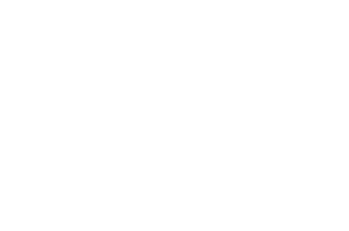

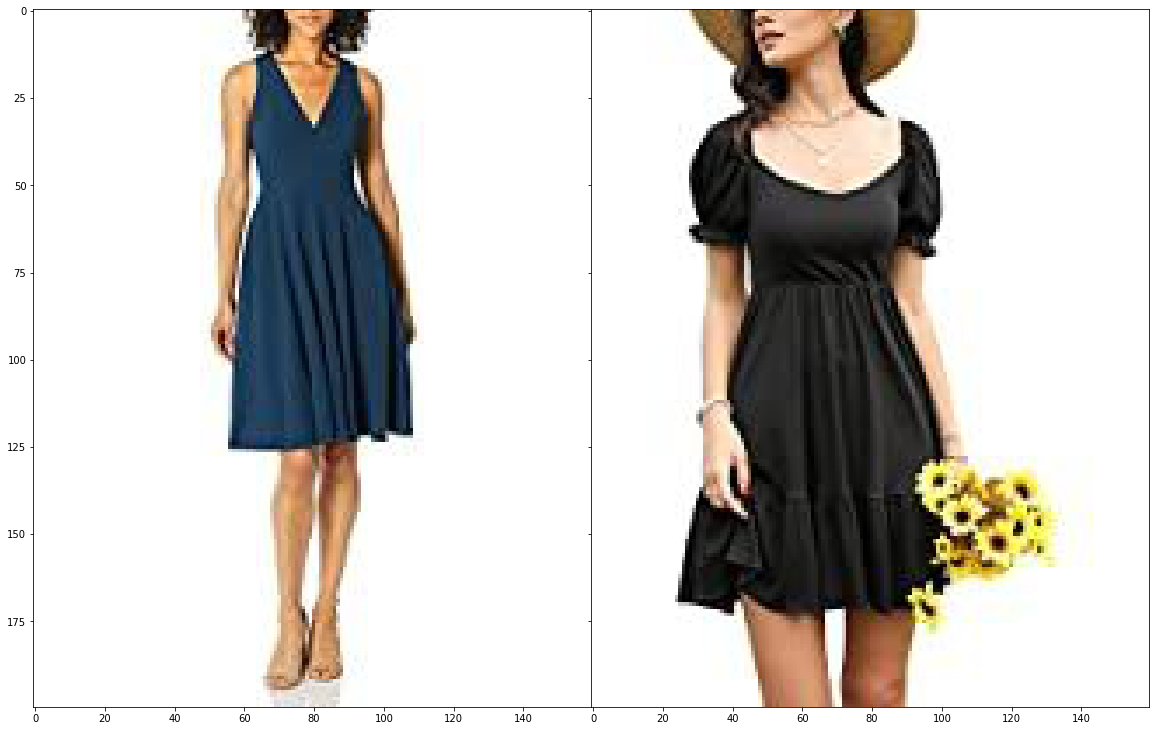

0.80 /content/Project_Find_My_Dress/data/original/midi_5.jpg /content/Project_Find_My_Dress/data/test/short_4.jpg
Example 2


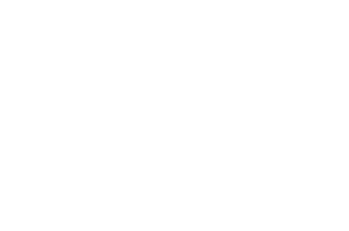

0.63 /content/Project_Find_My_Dress/data/original/short_3.jpg /content/Project_Find_My_Dress/data/test/midi_14.jpg
Example 3


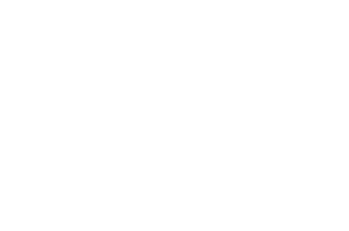

0.78 /content/Project_Find_My_Dress/data/original/gown_2.jpg /content/Project_Find_My_Dress/data/test/short_77.jpg
Example 4


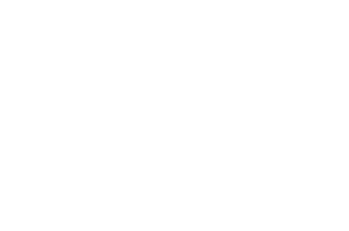

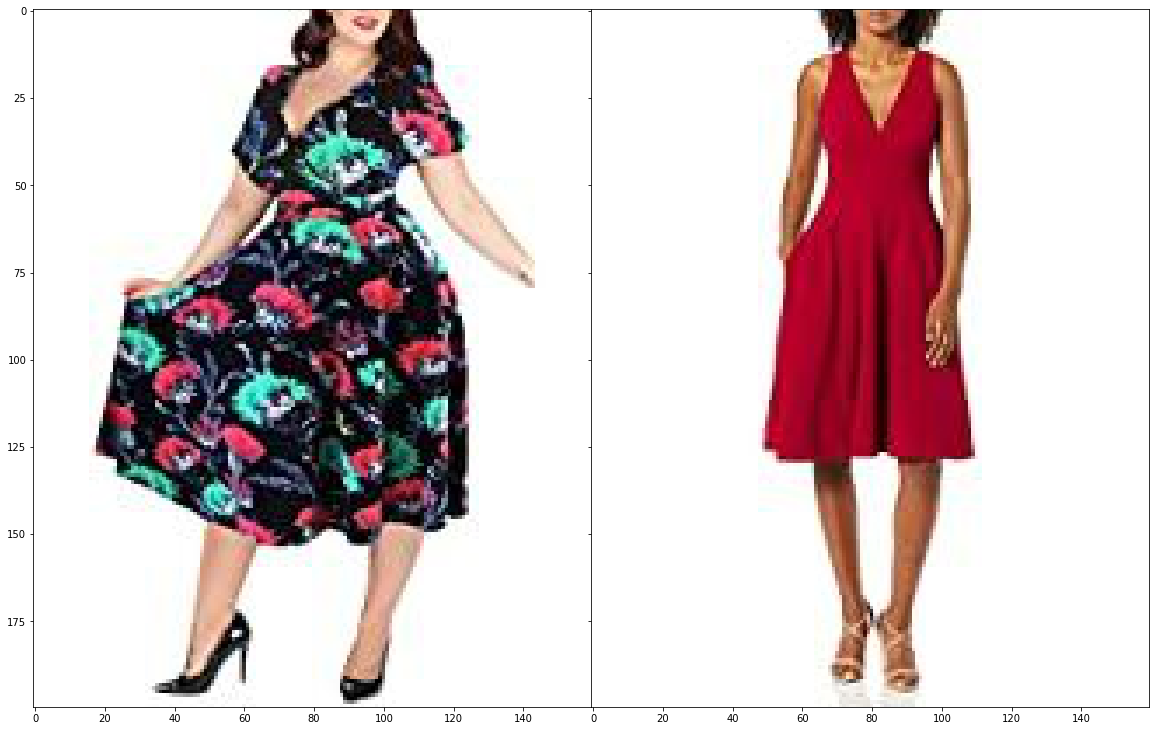

0.75 /content/Project_Find_My_Dress/data/original/midi_21.jpg /content/Project_Find_My_Dress/data/test/midi_6.jpg
Example 5


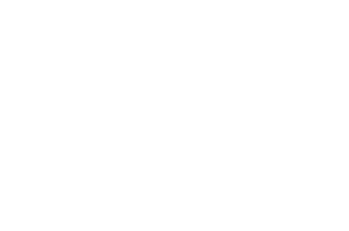

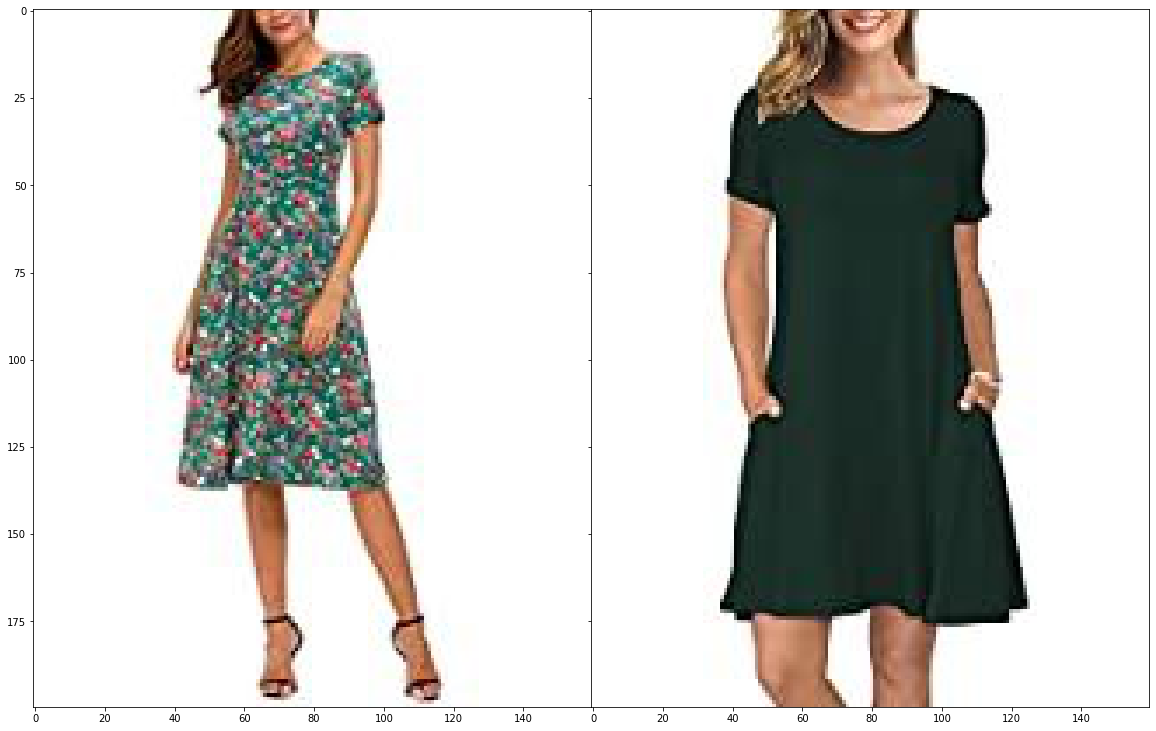

0.87 /content/Project_Find_My_Dress/data/original/midi_13.jpg /content/Project_Find_My_Dress/data/test/midi_2.jpg
Example 6


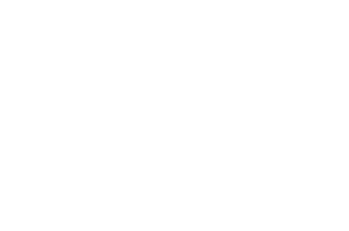

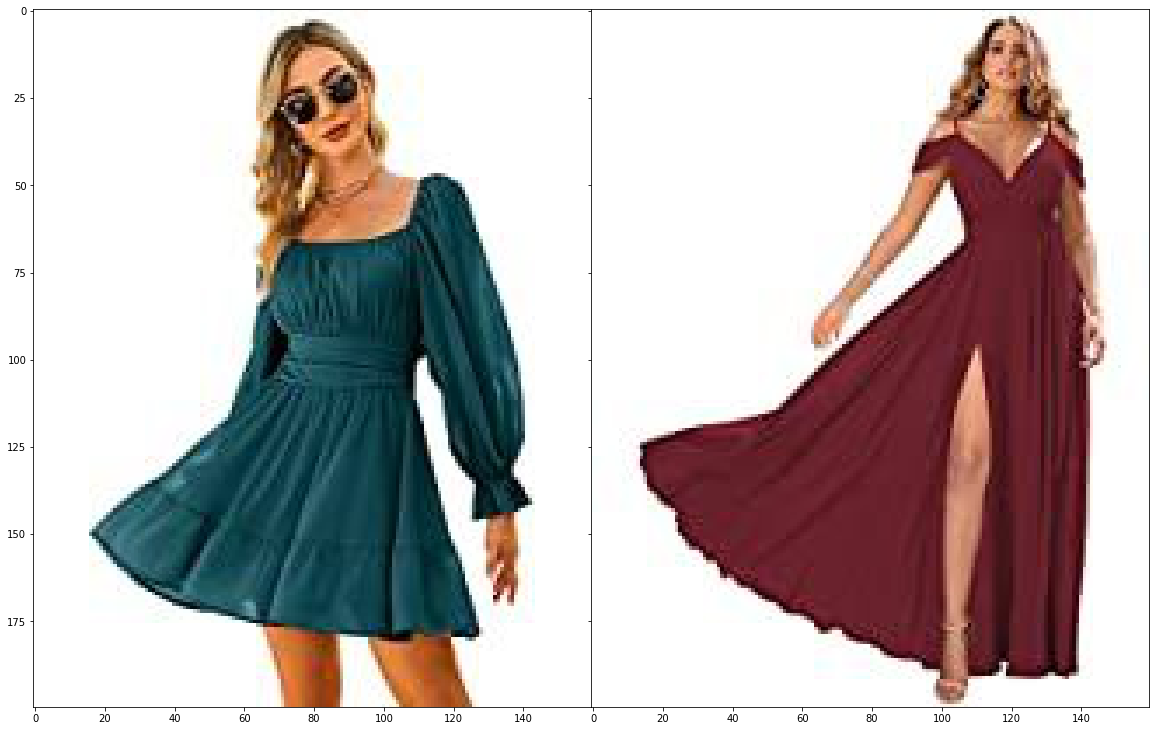

0.18 /content/Project_Find_My_Dress/data/original/short_7.jpg /content/Project_Find_My_Dress/data/test/gown_5.jpg
Example 7


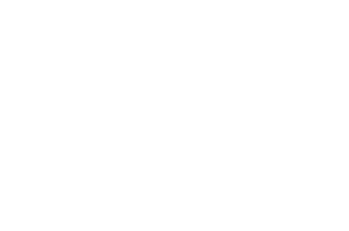

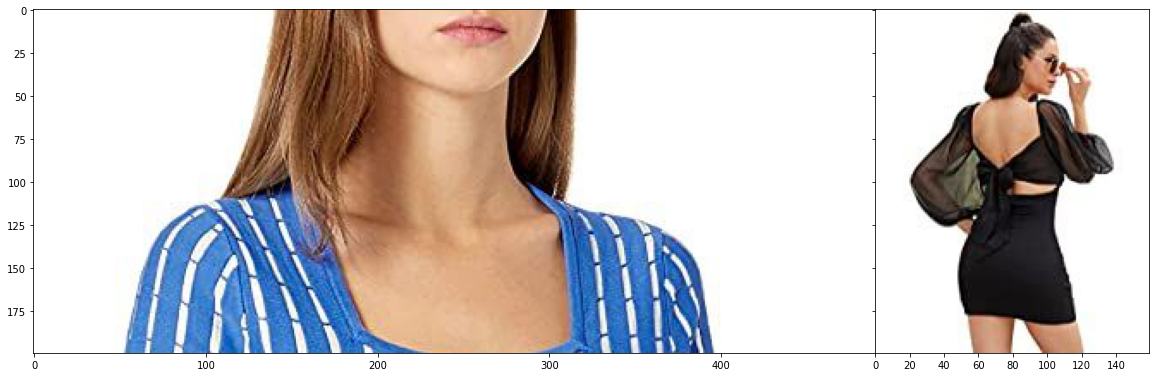

0.64 /content/Project_Find_My_Dress/data/original/midi_19.jpg /content/Project_Find_My_Dress/data/test/short_1.jpg
Example 8


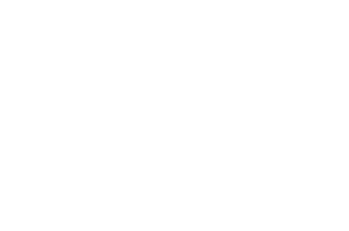

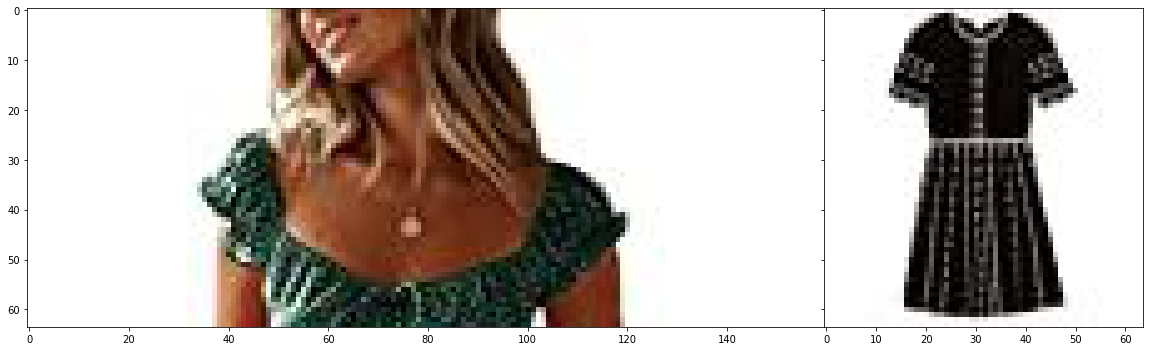

0.68 /content/Project_Find_My_Dress/data/original/short_5.jpg /content/Project_Find_My_Dress/data/test/4122emOhsqL._SS64_.jpg
Example 9


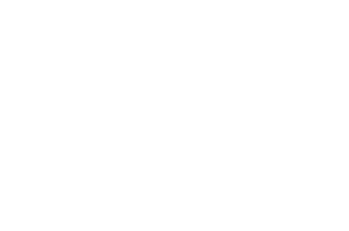

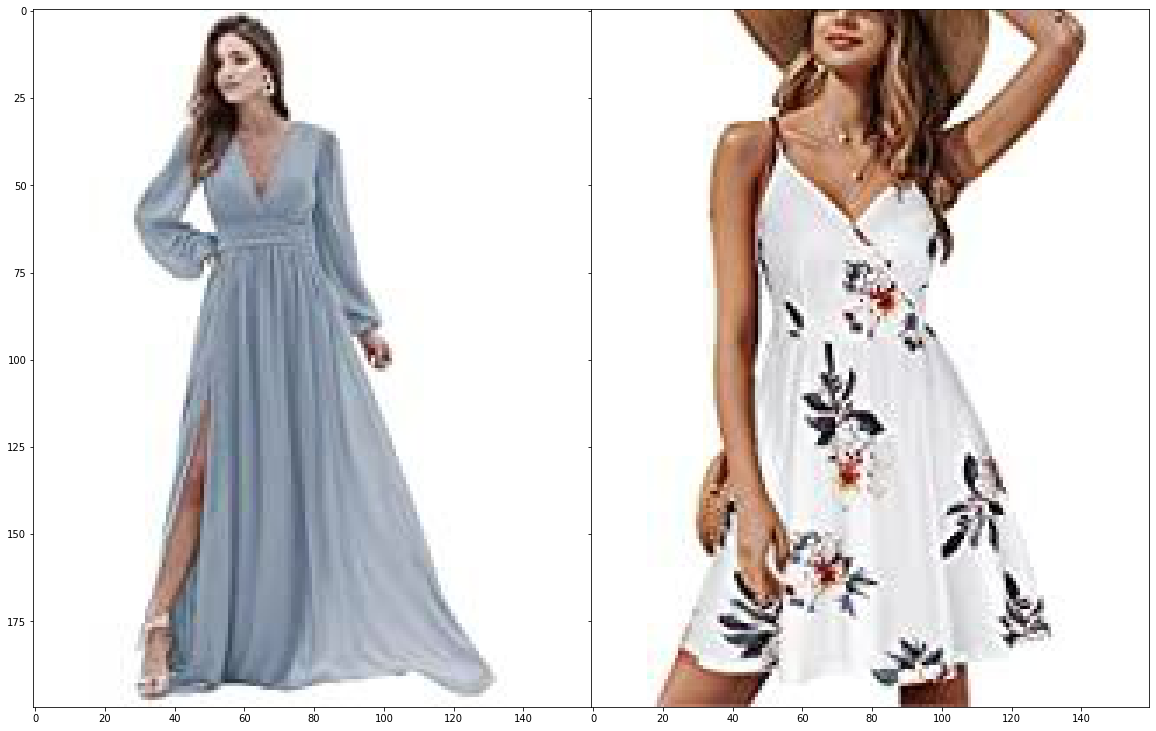

0.62 /content/Project_Find_My_Dress/data/original/gown_4.jpg /content/Project_Find_My_Dress/data/test/midi_12.jpg
Example 10


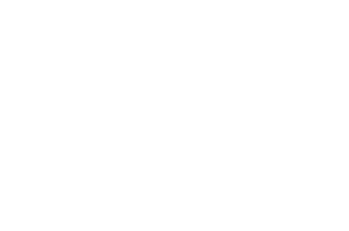

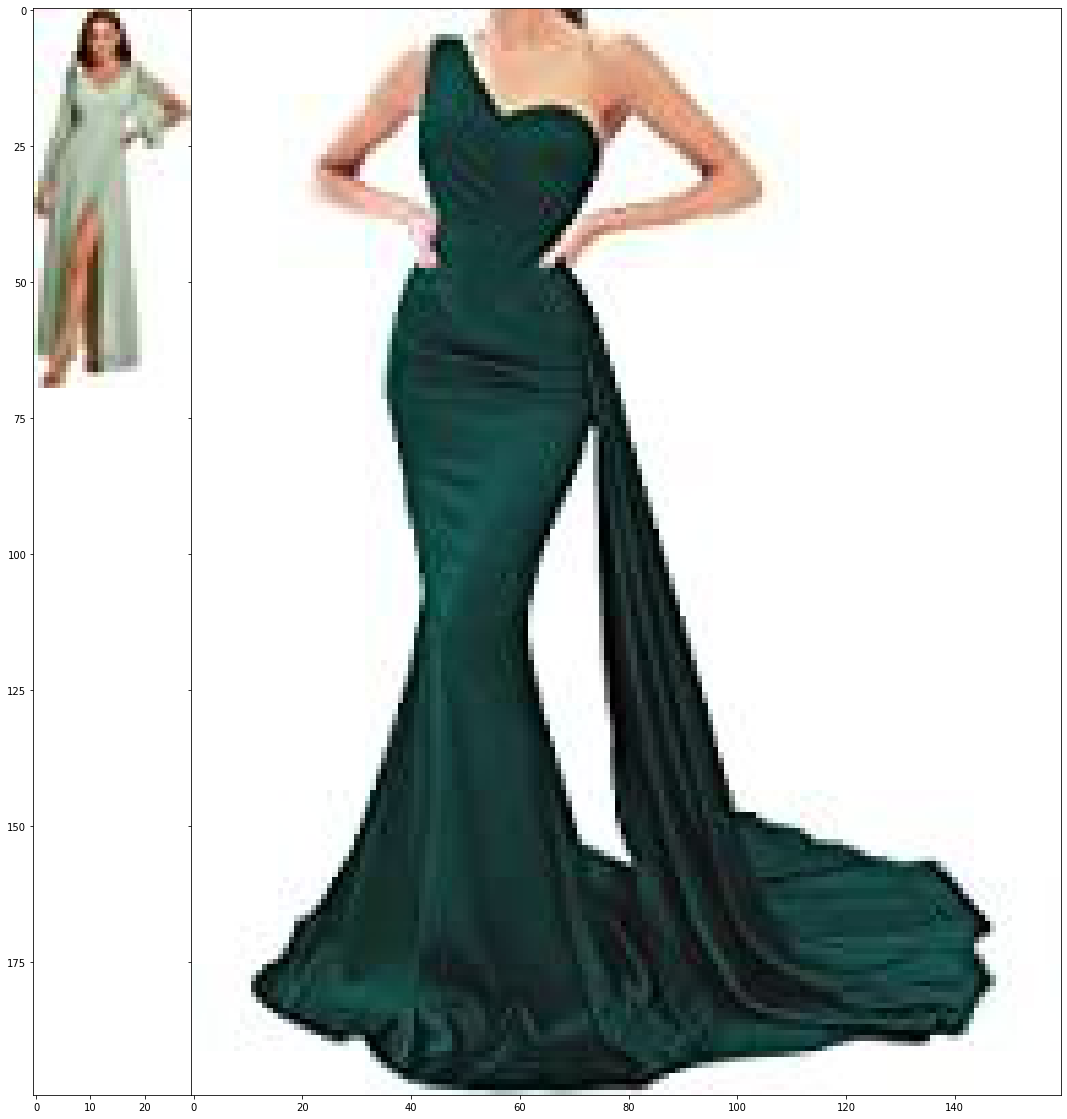

1.48 /content/Project_Find_My_Dress/data/original/gown_8.jpg /content/Project_Find_My_Dress/data/test/gown_6.jpg
Example 11


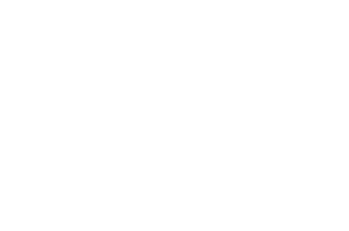

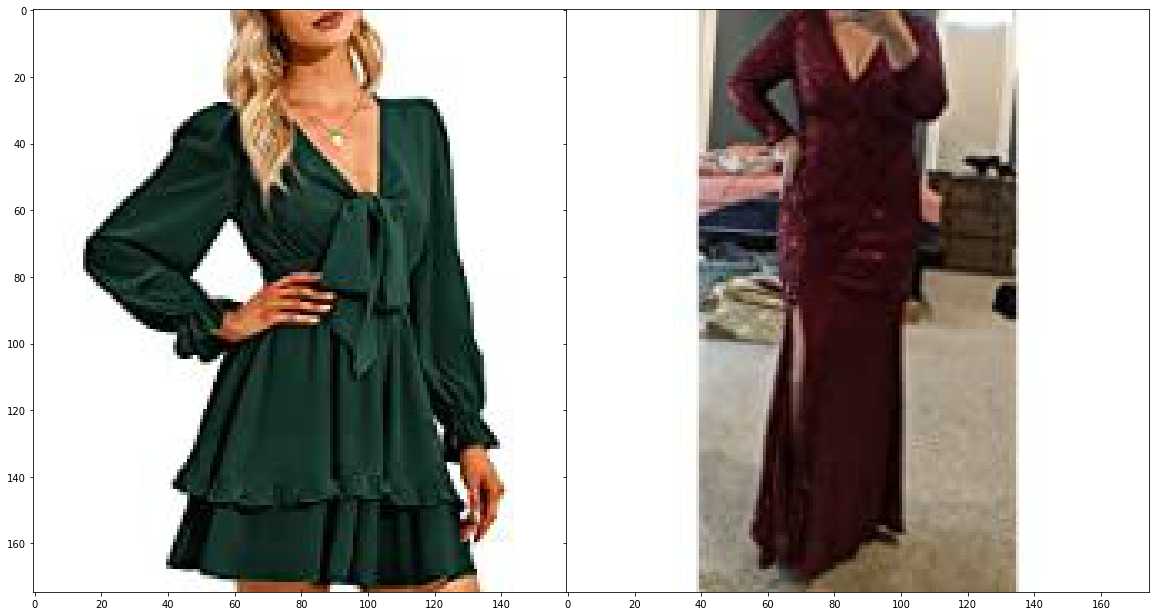

0.49 /content/Project_Find_My_Dress/data/original/short_2.jpg /content/Project_Find_My_Dress/data/test/gown3.jpg
Example 12


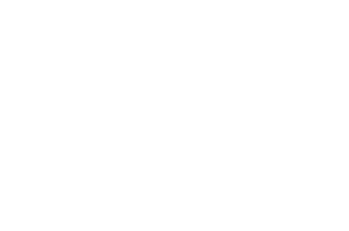

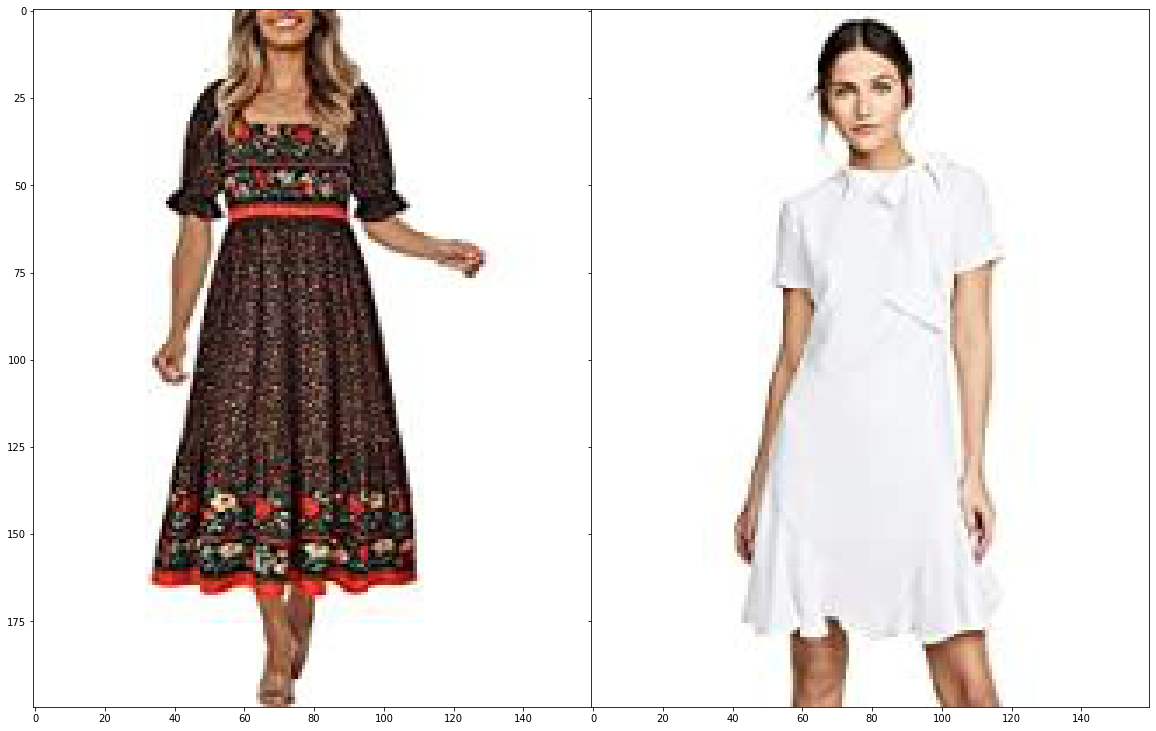

0.64 /content/Project_Find_My_Dress/data/original/midi_17.jpg /content/Project_Find_My_Dress/data/test/midi_1.jpg
Example 13


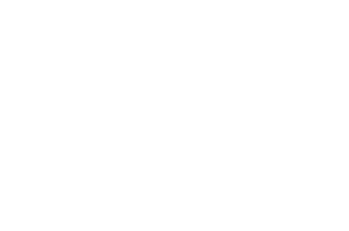

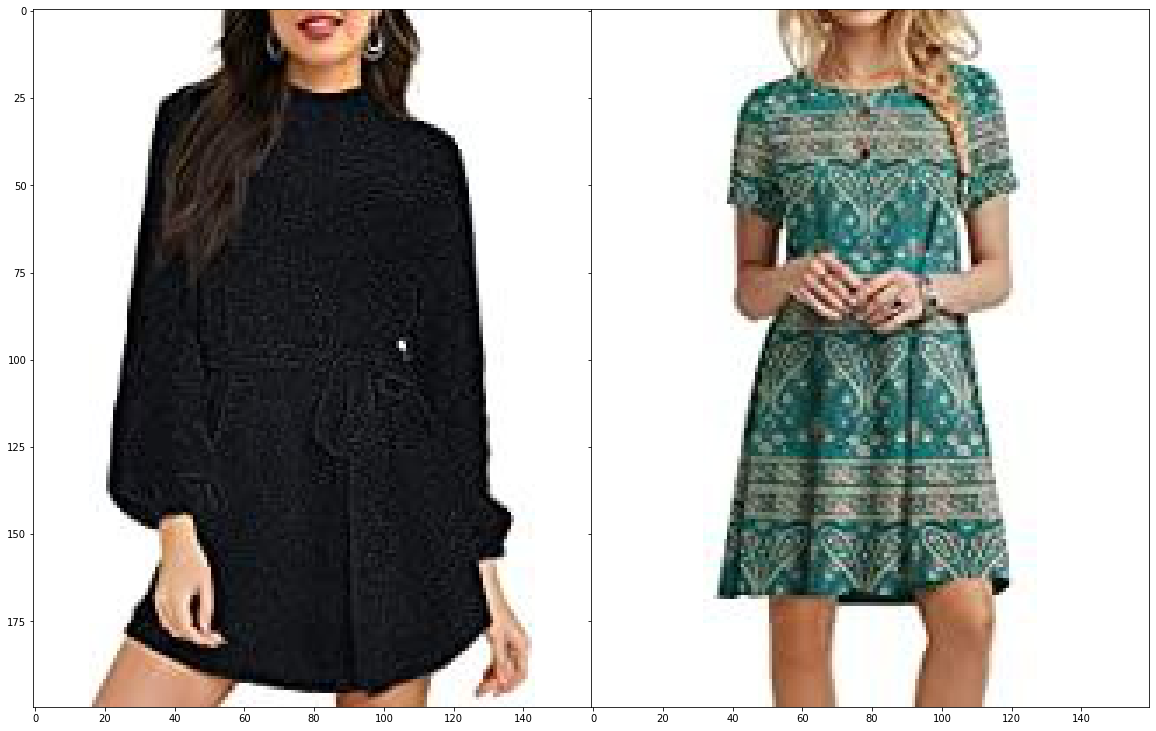

0.84 /content/Project_Find_My_Dress/data/original/midi_11.jpg /content/Project_Find_My_Dress/data/test/midi_18.jpg
Example 14


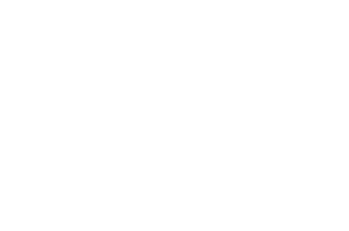

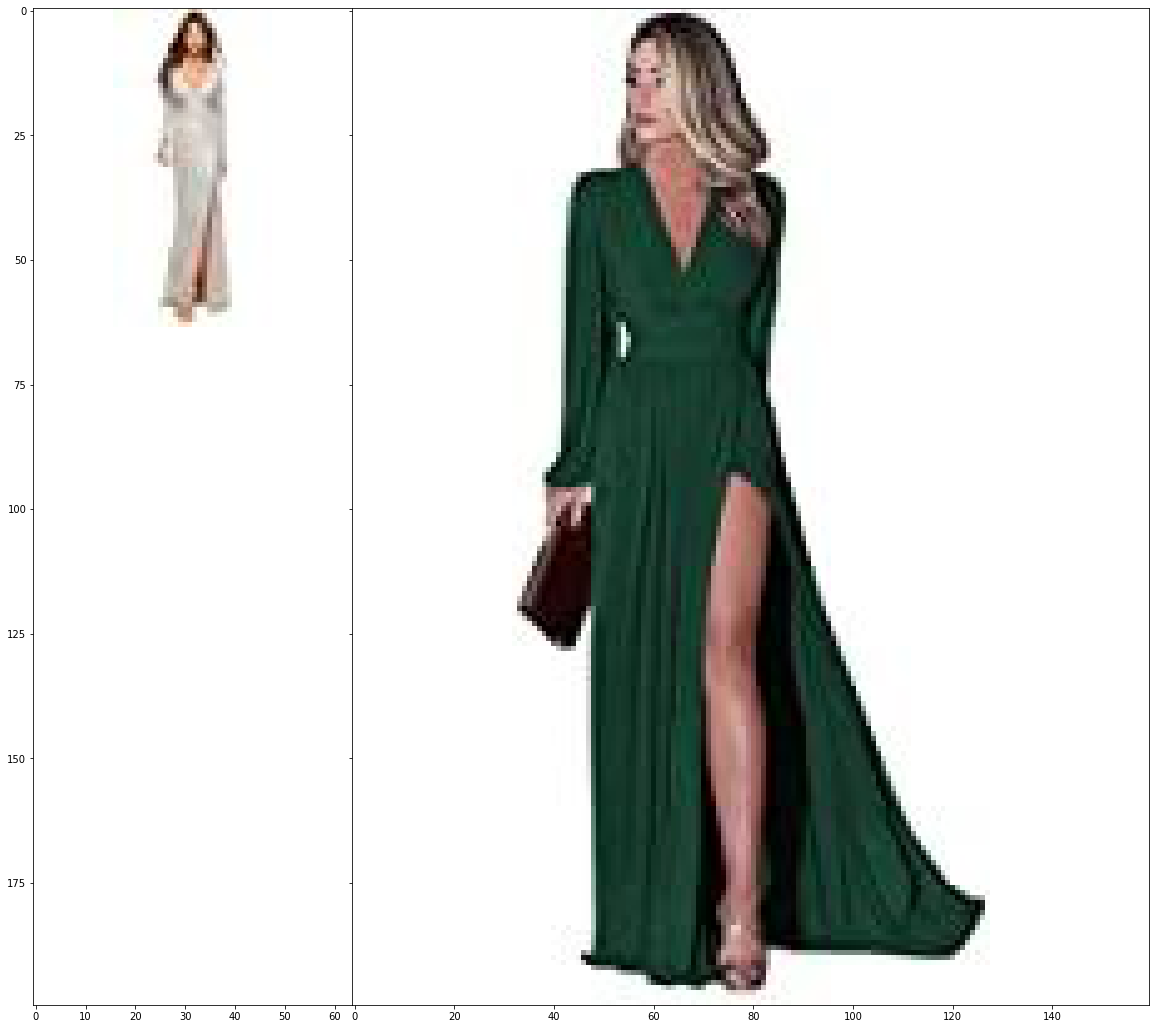

0.43 /content/Project_Find_My_Dress/data/original/gown_7.jpg /content/Project_Find_My_Dress/data/test/gown_1.jpg
Example 15


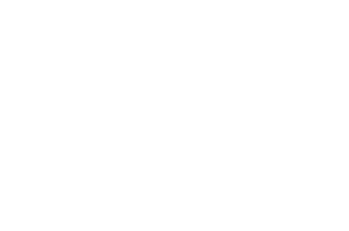

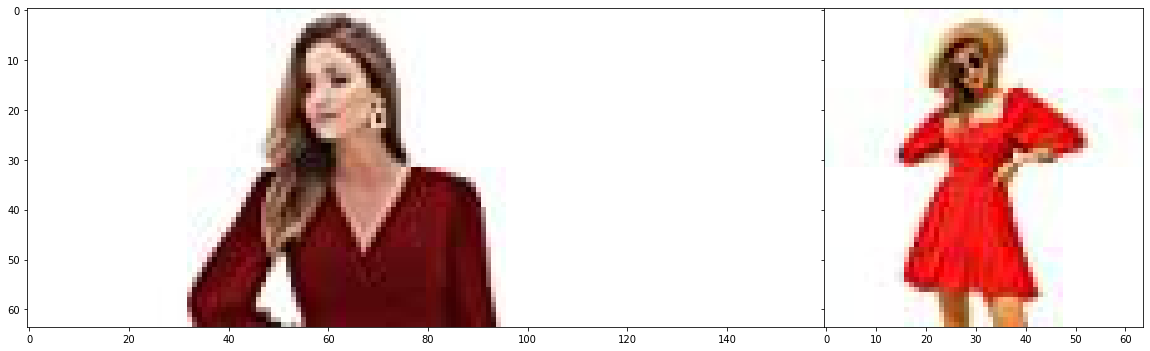

0.21 /content/Project_Find_My_Dress/data/original/gown_1.jpg /content/Project_Find_My_Dress/data/test/short_33.jpg
Example 16


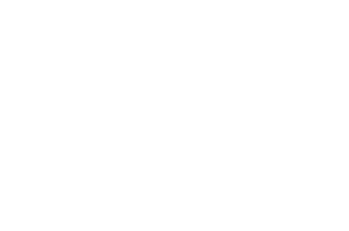

0.82 /content/Project_Find_My_Dress/data/original/midi_7.jpg /content/Project_Find_My_Dress/data/test/midi_8.jpg
Example 17


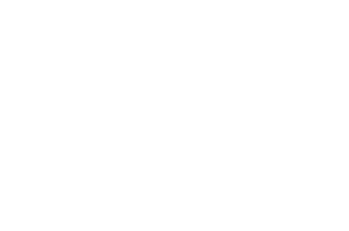

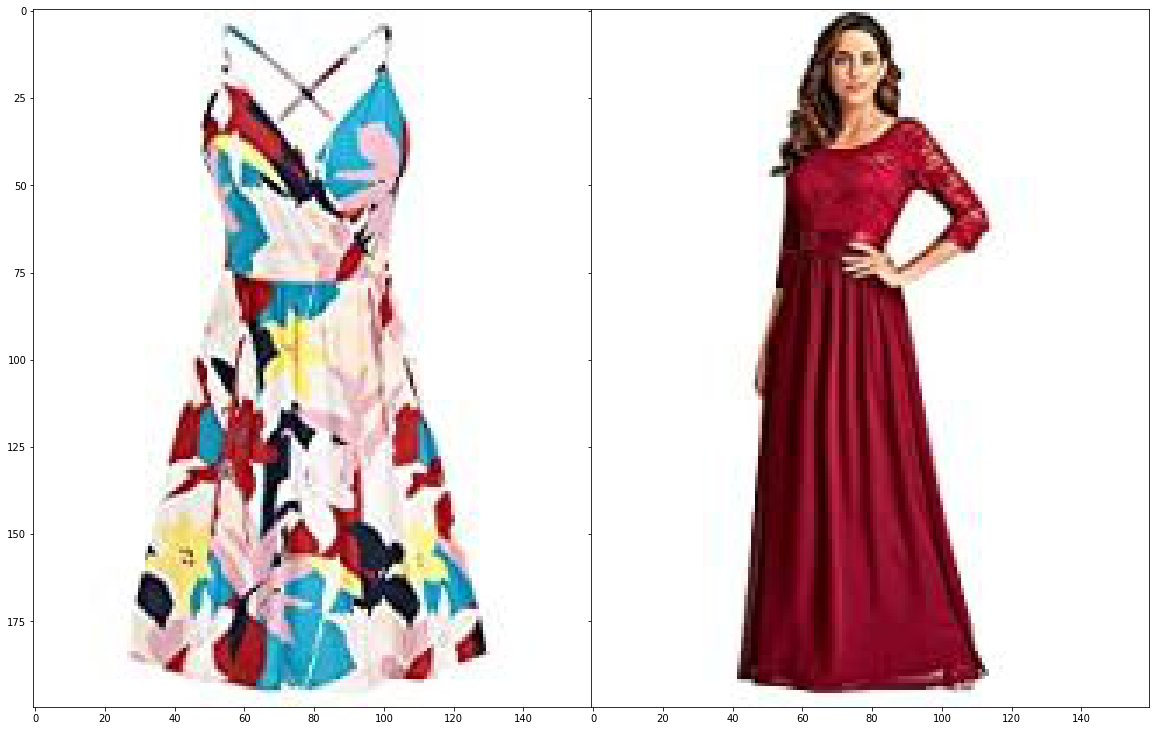

0.42 /content/Project_Find_My_Dress/data/original/midi_9.jpg /content/Project_Find_My_Dress/data/test/gown_7.jpg
Example 18


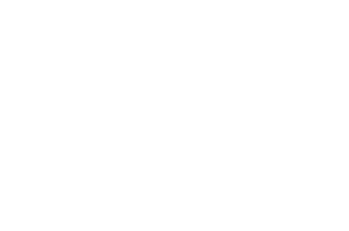

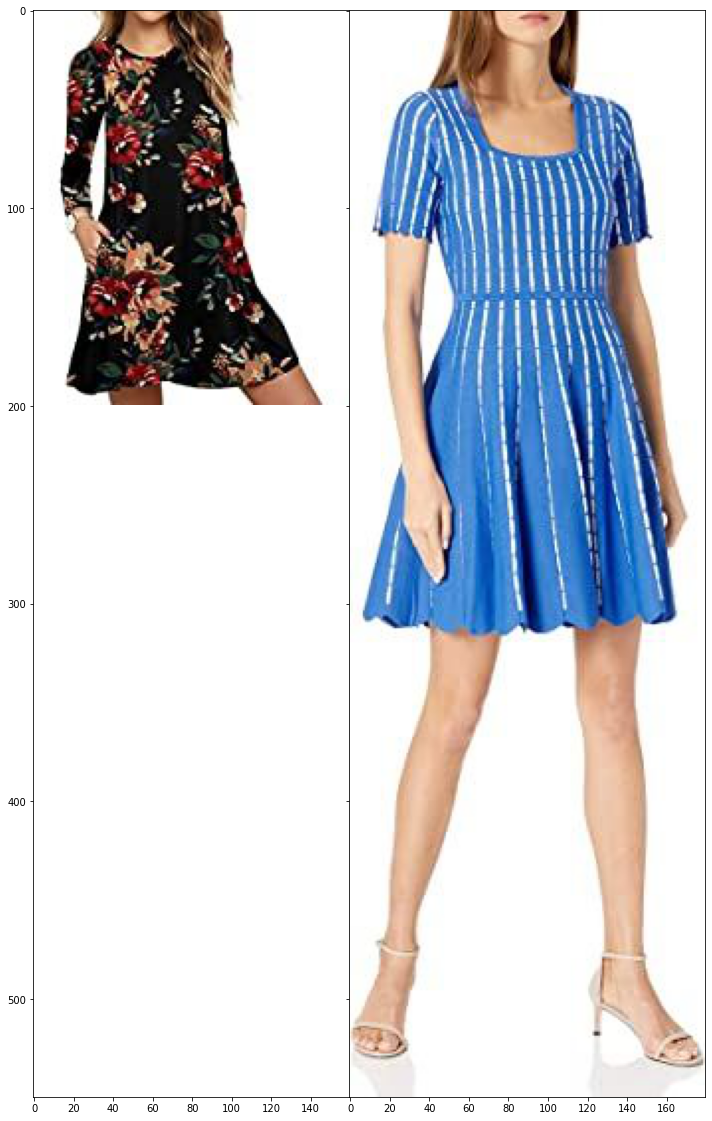

0.56 /content/Project_Find_My_Dress/data/original/short_10.jpg /content/Project_Find_My_Dress/data/test/midi_20.jpg
Example 19


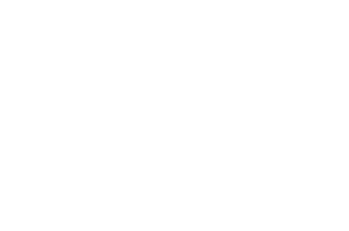

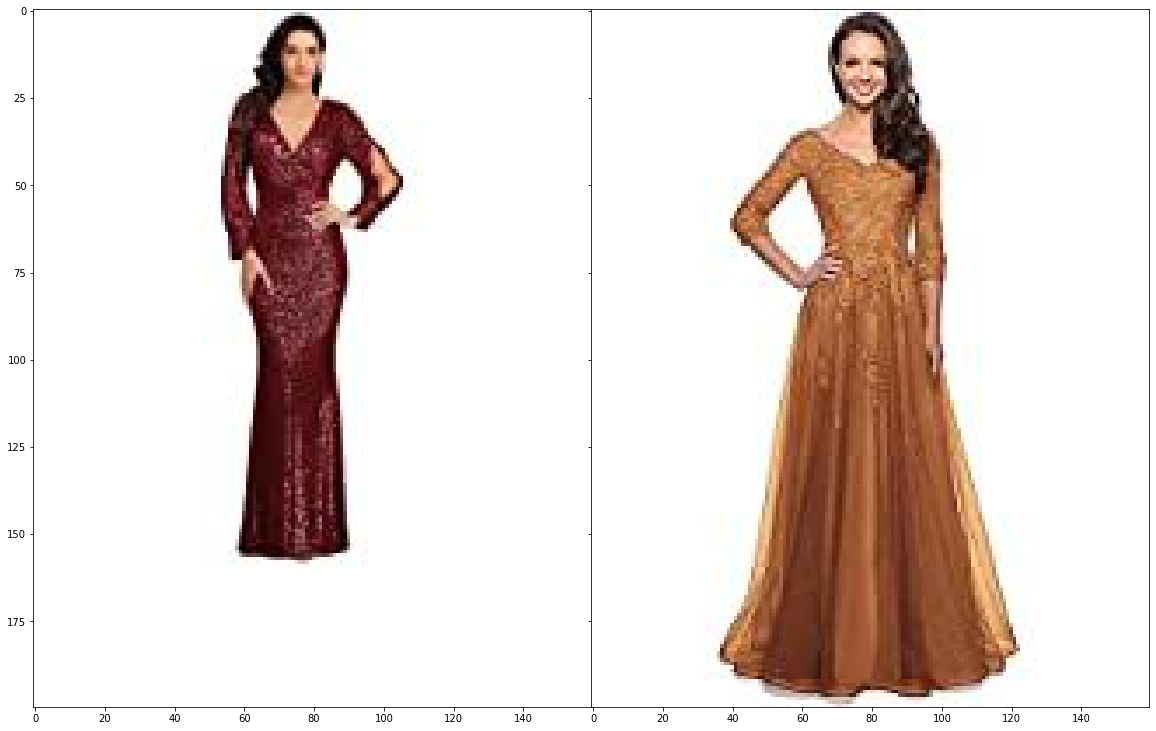

0.50 /content/Project_Find_My_Dress/data/original/gown3.jpg /content/Project_Find_My_Dress/data/test/gown_8.jpg
Example 20


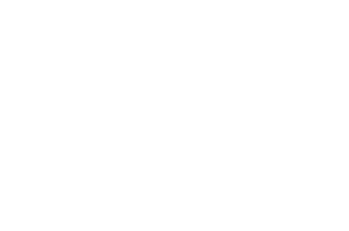

0.25 /content/Project_Find_My_Dress/data/original/short_11.jpg /content/Project_Find_My_Dress/data/test/gown_4.jpg
Example 21


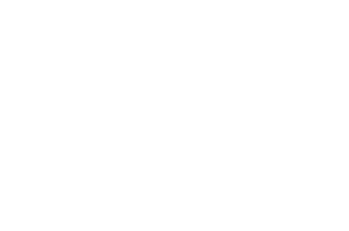

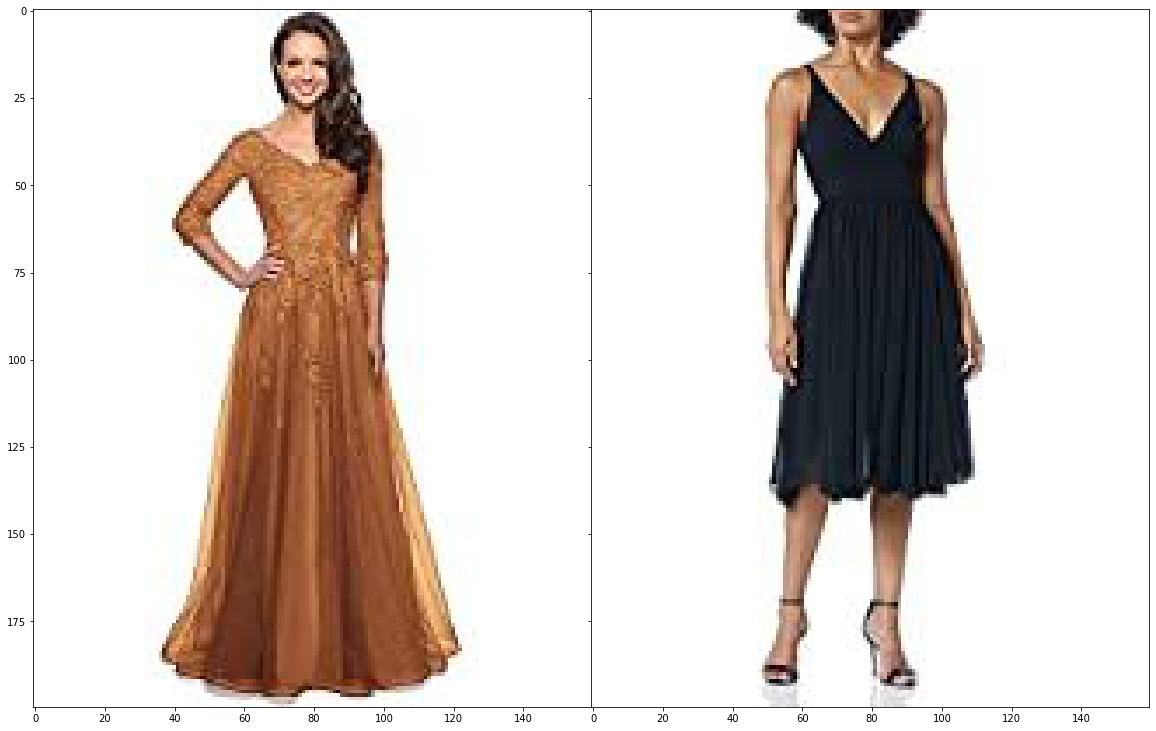

0.24 /content/Project_Find_My_Dress/data/original/gown_6.jpg /content/Project_Find_My_Dress/data/test/midi_3.jpg
Example 22


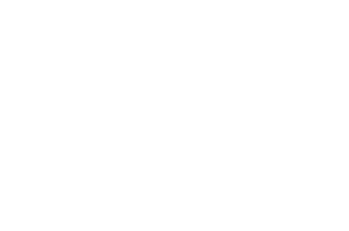

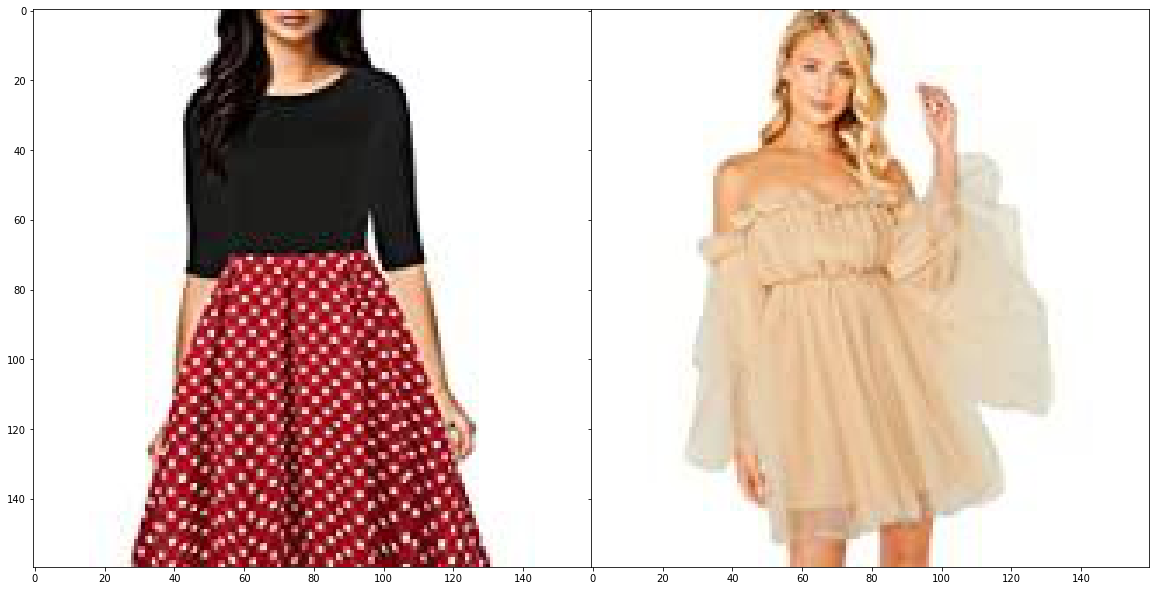

0.42 /content/Project_Find_My_Dress/data/original/midi_16.jpg /content/Project_Find_My_Dress/data/test/short_8.jpg
Example 23


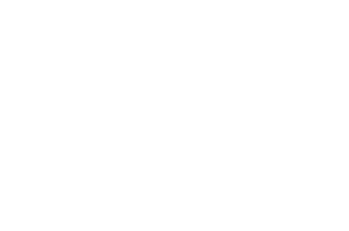

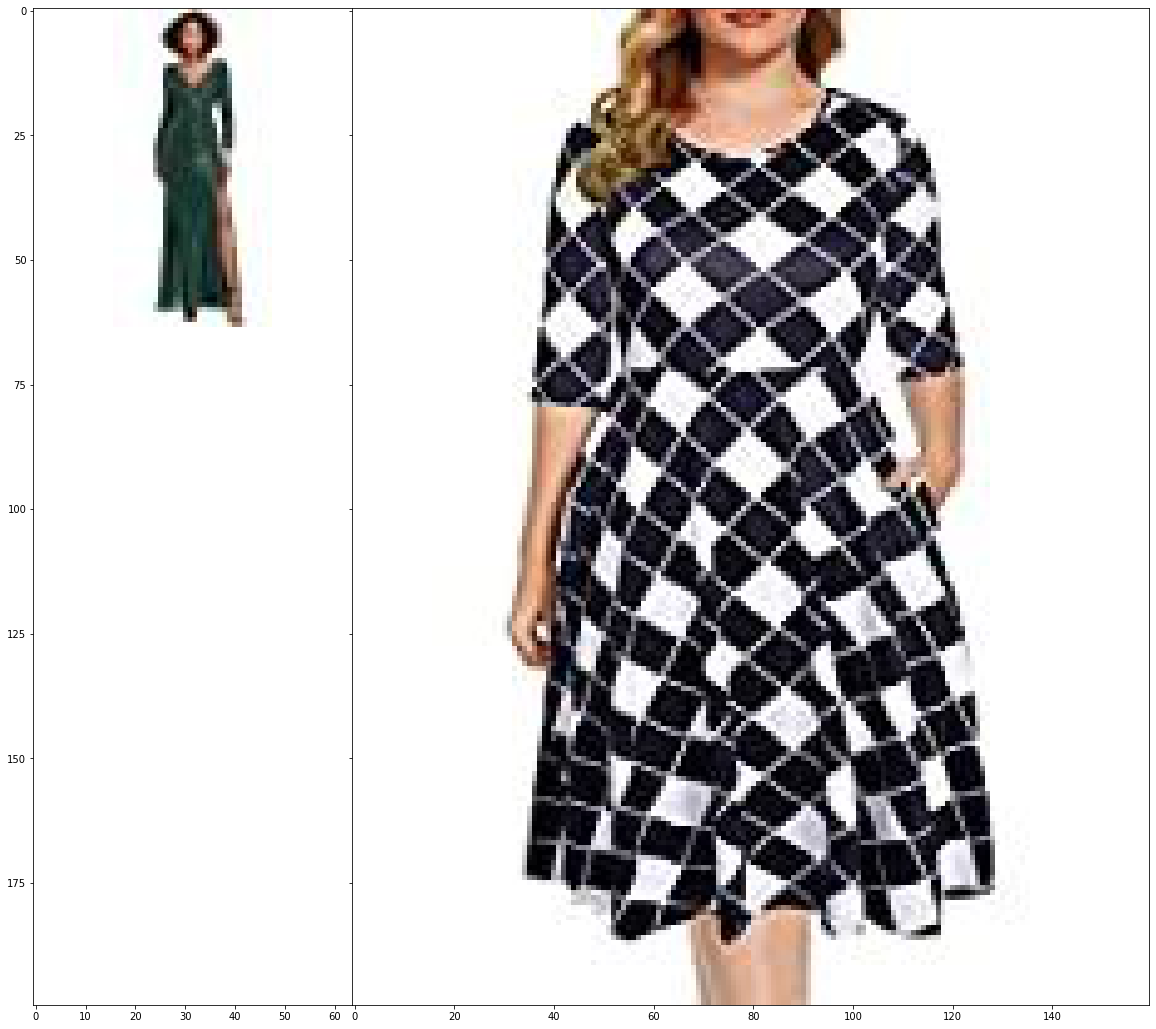

0.98 /content/Project_Find_My_Dress/data/original/gown_5.jpg /content/Project_Find_My_Dress/data/test/midi_22.jpg
Example 24


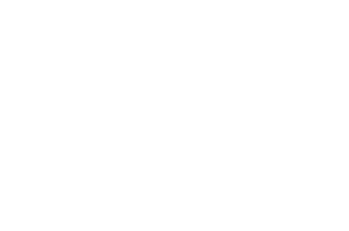

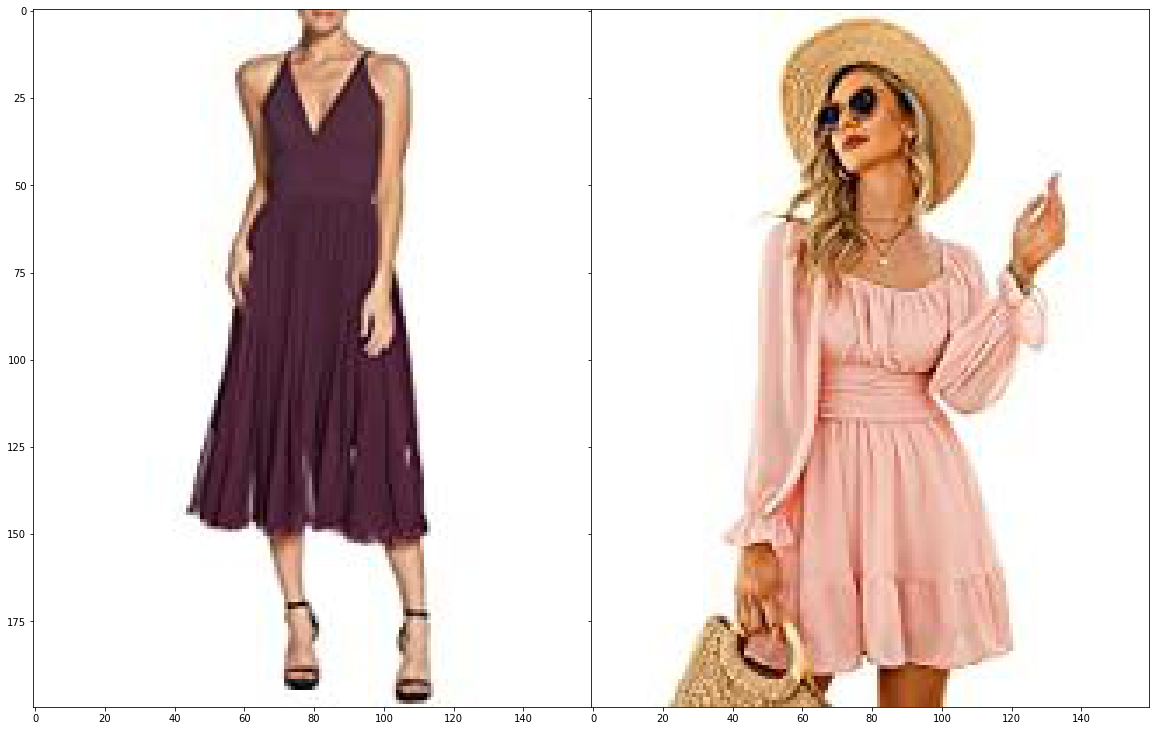

0.54 /content/Project_Find_My_Dress/data/original/midi_4.jpg /content/Project_Find_My_Dress/data/test/short_6.jpg
Example 25


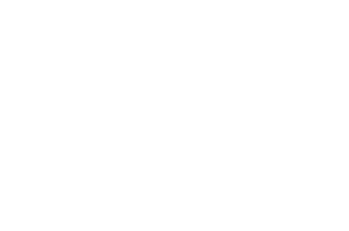

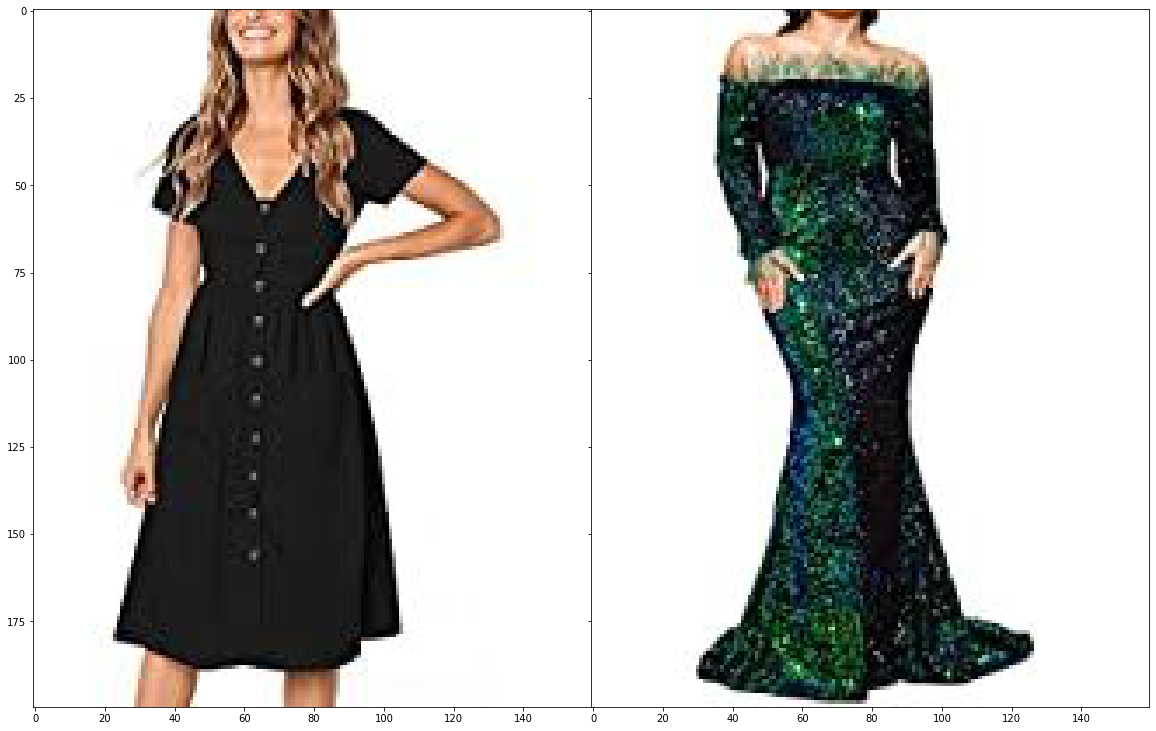

0.48 /content/Project_Find_My_Dress/data/original/midi_15.jpg /content/Project_Find_My_Dress/data/test/gown_2.jpg


In [45]:
i=0
for index, mytuple in enumerate(pairs_list):
    element_one = mytuple[0]
    element_two = mytuple[1]
    i=i+1
    print("Example " + str(i))  
    rgb_display(mytuple[0], mytuple[1])
    euclidean_distance_image(element_one, element_two)

In [51]:

mini_red = "/content/Project_Find_My_Dress/data/original/short_3.jpg"
mini_red_same = "/content/Project_Find_My_Dress/data/test/short_33.jpg"
mini_pink_same = "/content/Project_Find_My_Dress/data/test/short_6.jpg"


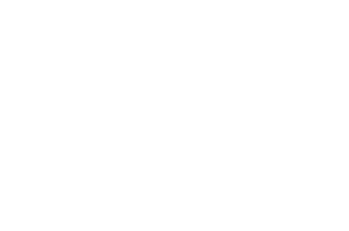

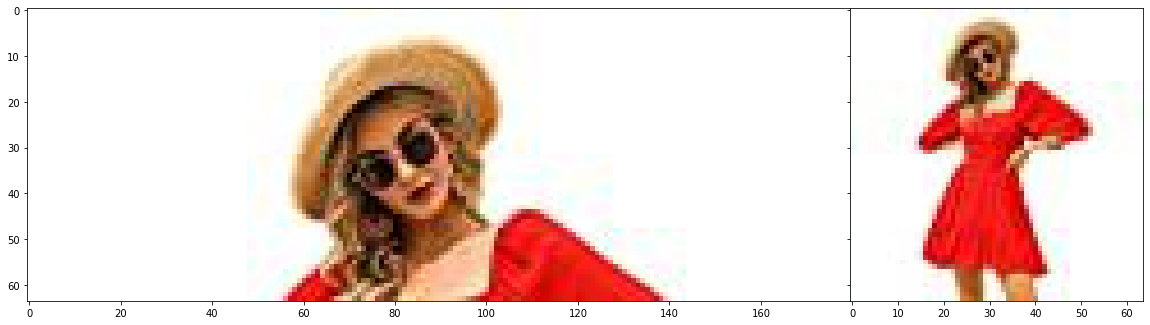

0.11 /content/Project_Find_My_Dress/data/original/short_3.jpg /content/Project_Find_My_Dress/data/test/short_33.jpg


('0.11',
 '/content/Project_Find_My_Dress/data/original/short_3.jpg',
 '/content/Project_Find_My_Dress/data/test/short_33.jpg')

In [50]:
rgb_display(mini_red, mini_red_same)
euclidean_distance_image(mini_red, mini_red_same)

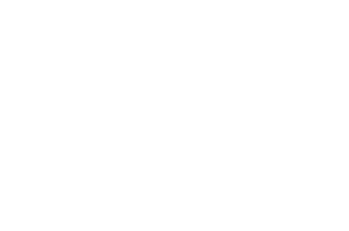

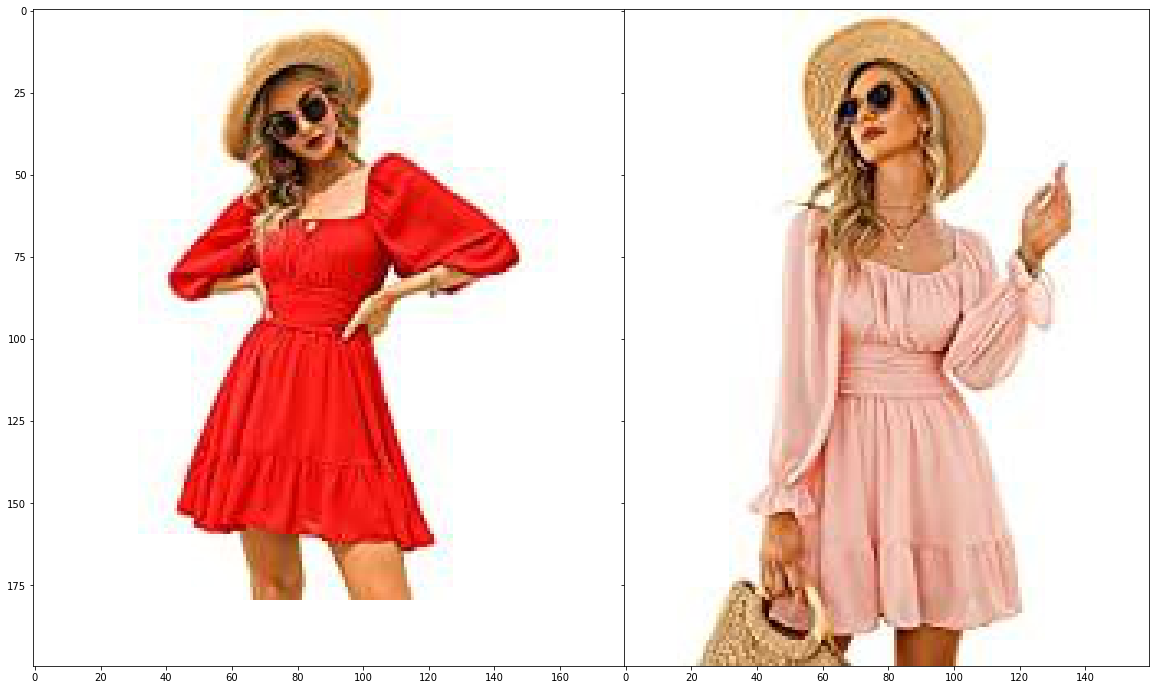

0.38 /content/Project_Find_My_Dress/data/original/short_3.jpg /content/Project_Find_My_Dress/data/test/short_6.jpg


('0.38',
 '/content/Project_Find_My_Dress/data/original/short_3.jpg',
 '/content/Project_Find_My_Dress/data/test/short_6.jpg')

In [53]:
rgb_display(mini_red, mini_pink_same)
euclidean_distance_image(mini_red, mini_pink_same)